## What are the steps in this analysis:
1. Break down primary sector into our main themes from our taxonomy (one hot encoding or make dictionary)
2. Begin labelling from project description

## Further analysis:
1. Illustrate how funding has changed over time 
2. Find examples of eco-funding in deprived areas
3. Developed a qualititve measure of how confident we are in our labels
4. What locations are failing to be funded?

## Potential problems:
1. Does the search query gather all the data that we want?
2. Significant number of NAs 
3. Low data quality - Loads of spelling and syntax errors 

In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pandas_ods_reader import read_ods
import seaborn as sns
from openpyxl import Workbook


In [2]:
pd.reset_option("display")
#pd.set_option("display.max_columns", 60)

In [3]:
cwd = os.getcwd()
cwd
os.chdir("C:/Users/44792/Documents/FEA/PtC")

In [4]:
df = pd.read_csv('grantee_report.csv', encoding='latin-1', parse_dates= ['First Award Date'],  header = 1)

Step 1: Eliminate irrelevant sectors:
Dictionary Approach

Keep: 

Transport
Transportation
Housing
Provision of Housing
Energy 
Energy; Housing; Income or financial inclusion
Food catering or production (incl. farming)
Waste Reduction Re-use or Recycling
Waste Reduction, Reuse or Recycling
Environmnet or nature
Environment or Nature
Environment or Nature; Other
Environmental or nature conservation
Environmental or nature conservation, Employment support or training
Environment or Nature; Health Care or Wellbeing
Horticulture

In [6]:
df.head(2)

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,IMD Average,Status,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information
0,0011p000021ty1wAAA,APP-04653,Next Generation Community Energy (NGCE),Yealm Community Energy,Creacombe Project Development (NGCE),Community Benefit Society,NaN,NaN,Energy,NaN,...,0,Grant awarded,100000.0,0.0,2019-06-30,NaN,The following tasks have been identified for w...,NaN,NaN,NaN
1,0012400000RRaqAAAT,APP-01620,W.sale / Blended - Key Fund (KF),Riccall Regen 2000 Ltd,Riccall Regen 2000 (KF),Company Limited by Guarantee,NaN,NaN,"Community Centre Hub, Facility or Space","Community Pub, Shop or Café",...,6,Grant awarded,25000.0,0.0,2017-04-03,Community hub comprising of children's nursery...,To assist with capital costs of various refurb...,NaN,NaN,NaN


In [7]:
print(len(df.index))

2477


In [8]:
dictionary = {
    "Transport" : ['Transport', 'Transportation'],
    "Buildings" :  ['Housing','Provision of Housing'],
    "Energy" : ["Energy", "Energy; Housing; Income or financial inclusion"],
    "Food" : ["Food catering or production (incl. farming)", "Food Catering or Production (incl. Farming)", "Food and Drink, Community,", "Food Catering or Production (incl. Farming); Health Care or Wellbeing",
             "Food catering and production/farming"],
    "Waste and Consumption" : ["Waste Reduction Re-use or Recycling", "Waste Reduction, Reuse or Recycling"],
    "Natural Environment" : ["Environment or nature", "Environment or Nature","Environment or Nature; Other", "Environment or nature conservation","Environment or nature conservation, Employment support or training", 
                             "Environment or Nature; Health Care or Wellbeing", "Horticulture"]
}
print("Dictionary Keys are the following: ")
print(dictionary.keys())
print("Dictionary values are the following: ")
print(dictionary.values())


Dictionary Keys are the following: 
dict_keys(['Transport', 'Buildings', 'Energy', 'Food', 'Waste and Consumption', 'Natural Environment'])
Dictionary values are the following: 
dict_values([['Transport', 'Transportation'], ['Housing', 'Provision of Housing'], ['Energy', 'Energy; Housing; Income or financial inclusion'], ['Food catering or production (incl. farming)', 'Food Catering or Production (incl. Farming)', 'Food and Drink, Community,', 'Food Catering or Production (incl. Farming); Health Care or Wellbeing', 'Food catering and production/farming'], ['Waste Reduction Re-use or Recycling', 'Waste Reduction, Reuse or Recycling'], ['Environment or nature', 'Environment or Nature', 'Environment or Nature; Other', 'Environment or nature conservation', 'Environment or nature conservation, Employment support or training', 'Environment or Nature; Health Care or Wellbeing', 'Horticulture']])


In [9]:
dict_new = {}
def dict_map(dict_name_init, dict_name_new, column_change):
    """
    Create a new dictionary which reverses the keys and values. 
    Then replaces the old terms 
    """
    dict_name_new = {keys: old_keys for old_keys, old_values in dict_name_init.items() for keys in old_values}
    column_change = column_change.replace(dict_name_new)

dict_map(dict_name_init = dictionary, dict_name_new = dict_new, column_change = df['Primary Sector - Org'])

In [10]:
dict_new = {keys: old_keys for old_keys, old_values in dictionary.items() for keys in old_values}
df['Primary Sector - Org'] = df['Primary Sector - Org'].replace(dict_new)

Here I am cleaning the Primary Sector Vector: 

In [11]:
df['Primary Sector - Org'] = df['Primary Sector - Org'].str.replace("Community Centre Hub, Facility or Space", "xyz")
df['Primary Sector - Org'] = df['Primary Sector - Org'].str.replace("Employment, training, business support or education", "xyz")
df['Secondary Sector - Org'] = df['Secondary Sector - Org'].astype(str)
df['Primary Sector - Org'] = df['Primary Sector - Org'].astype(str) 
df['Primary Sector - Org'] = df.apply(lambda x: x['Primary Sector - Org'].replace('xyz', x['Secondary Sector - Org']), axis=1)
df['Primary Sector - Org'].fillna(df['Secondary Sector - Org'], inplace=True)

In [12]:
def clean_primary_vec(primary, string, secondary):
    
    """
    This cleans the primary sector vector
    """
    
    primary = primary.str.replace(string, "xyz")
    secondary = secondary.astype(str)
    primary = primary.astype(str) 
    primary = df.apply(lambda x: x['Primary Sector - Org'].replace('xyz', x['Secondary Sector - Org']), axis=1)
    primary.fillna(secondary, inplace=True)
    
clean_primary_vec(primary = df['Primary Sector - Org'], string = "Community Centre Hub, Facility or Space", secondary = df['Secondary Sector - Org'])
clean_primary_vec(primary = df['Primary Sector - Org'], string = "Employment, training, business support or education", secondary = df['Secondary Sector - Org'])
df.head(3)

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,IMD Average,Status,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information
0,0011p000021ty1wAAA,APP-04653,Next Generation Community Energy (NGCE),Yealm Community Energy,Creacombe Project Development (NGCE),Community Benefit Society,NaN,NaN,Energy,nan,...,0,Grant awarded,100000.0,0.0,2019-06-30,NaN,The following tasks have been identified for w...,NaN,NaN,NaN
1,0012400000RRaqAAAT,APP-01620,W.sale / Blended - Key Fund (KF),Riccall Regen 2000 Ltd,Riccall Regen 2000 (KF),Company Limited by Guarantee,NaN,NaN,"Community Pub, Shop or Café","Community Pub, Shop or Café",...,6,Grant awarded,25000.0,0.0,2017-04-03,Community hub comprising of children's nursery...,To assist with capital costs of various refurb...,NaN,NaN,NaN
2,00124000018h524AAA,APP-01619,W.sale / Blended - SASC (SASC),Gawcott Fields Community Solar Project C.I.C.,Gawcott Fields Community Solar Project C.I.C. ...,Community Interest Company Limited by Shares,NaN,NaN,Energy,nan,...,9,Grant awarded,150000.0,0.0,2017-01-03,Gawcott Fields Community Solar (GFCS) is a com...,Gawcott Fields Community Solar (GFCS) is a com...,NaN,NaN,NaN


In [59]:
#pd.set_option("display.max_colwidth", -1)
#test = df[df['App ID'] == "APP-00012"]
#test
#App ID == APP-00012 & APP-017921] 

In [13]:
extra = df[df["Primary Sector - Org"] == "Conservation of the environment;Employment support or training;Energy generation"]
extra

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,IMD Average,Status,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information
858,0012400000RRapwAAD,APP-00012,Innovation and Infrastructure (IIF),Repowering Limited,Creating Community Energy Businesses in London...,Community Benefit Society,Industrial and provident Society,NaN,Conservation of the environment;Employment sup...,Conservation of the environment;Employment sup...,...,2,Grant awarded,125000.0,0.0,2016-04-28,Succesful IIF bid to support development of a ...,Repowering Ltd supports communities to set up ...,NaN,NaN,NaN
1866,0012400000RRapwAAD,APP-01792,Innovation and Infrastructure (IIF),Repowering Limited,Repowering Ltd.Creating Community Energy Busin...,Community Benefit Society,Industrial and provident Society,NaN,Conservation of the environment;Employment sup...,Conservation of the environment;Employment sup...,...,2,Grant awarded,99600.0,0.0,2017-01-08,Succesful IIF bid to support development of a ...,Repowering Ltd supports communities to set up ...,NaN,NaN,NaN


In [14]:
len(df["Primary Sector - Org"].unique())
uniques = df["Primary Sector - Org"].unique()
new_uniques = list([x.split(";") for x in uniques])
flat_list = [item.strip() for sublist in new_uniques for item in sublist]
flat_list
set(flat_list)
len(set(flat_list))
#127

139

In [15]:
dictionary_sliced = {
    "Transport" : ['Transport', 'Transportation'],
    "Buildings" :  ['Housing','Provision of Housing',  'Construction Activities', 'Construction activities', 'Housing, Employment, training', 'business support or education'
                   'Shop', 'Community Space Hub or Centre'],
    "Energy" : ["Energy", "Energy; Housing; Income or financial inclusion", 'Energy Generation', "Conservation of the environment;Employment support or training;Energy generation"],
    "Food" : ["Food catering or production (incl. farming)", "Food Catering or Production (incl. Farming)", "Food and Drink, Community,", "Food Catering or Production (incl. Farming); Health Care or Wellbeing",
             "Food catering and production/farming", 'Play to tackle poverty and obesity', 'Prevention or relief of poverty', 'Physical Health or Wellbeing, Food Catering or Production (incl. Farming)',
             'Prevention or relief of poverty'],
    "Waste and Consumption" : ['Waste Reduction, Reuse or Recycling', 'Waste and Consumption', 'Community Shop', 'Shops / cafes', 'Shops/Cafes', 'Community pub, shop or caf_', 'Community pub, shop or cafe', 
                               'Community pub, shop or café',  'Community Pub, Shop or Café', 'Community Pub, Shop or Café'],
    "Natural Environment" : ['Conservation of the Environment','Conservation of the Environment or Nature', 'Conservation of the environment', "Horticultural",'Environment or Nature',
                             'Environment or nature', 'Environmental or nature conservation', 'Environmental or nature conservation, Employment support or training']
}

In [16]:
dictionary_sliced_rev = {keys: old_keys for old_keys, old_values in dictionary_sliced.items() for keys in old_values}
df['Primary Sector - Org'] = df['Primary Sector - Org'].replace(dictionary_sliced_rev)

In [17]:
dictionary_sliced_rev = {}
dict_map(dict_name_init = dictionary_sliced, dict_name_new = dictionary_sliced_rev, column_change = df['Primary Sector - Org'])

In [18]:
len(df["Primary Sector - Org"].unique())
# 137
#169

169

Here I will filter by our main categories:

In [19]:
main_categories = ["Transport", "Buildings", "Energy", "Food", "Waste and Consumption", "Natural Environment"]
df_filtered = df[df['Primary Sector - Org'].isin(main_categories)]
print("Total number of rows in filtered list: ")
print(len(df_filtered.index))
#830

Total number of rows in filtered list: 
833


In [20]:
print("Filtered Salesforce Funding: £", df_filtered['Total Grants Awarded'].sum()/1000000, "million")
print("Number of different Applications in filtered salesforce dataset:", len(df_filtered["App ID"].unique()))
print("Number of different Organisation IDs in filtered salesforce dataset:", len(df_filtered["18 characters Org ID"].unique()))
print("The total number of Energy grants is :", len(df_filtered[df_filtered['Primary Sector - Org'] == "Energy"]))
print("The total number of Transport grants is :",len(df_filtered[df_filtered['Primary Sector - Org'] == "Transport"]))
print("The total number of Building grants is :",len(df_filtered[df_filtered['Primary Sector - Org'] == "Buildings"]))
print("The total number of Food grants is :",len(df_filtered[df_filtered['Primary Sector - Org'] == "Food"]))
print("The total number of Waste and Consumption grants is :",len(df_filtered[df_filtered['Primary Sector - Org'] == "Waste and Consumption"]))
print("The total number of Natural Environment grants is :",len(df_filtered[df_filtered['Primary Sector - Org'] == "Natural Environment"]))
print("The total number of grant applications are: ", len(df_filtered.index))

Filtered Salesforce Funding: £ 30.27360671 million
Number of different Applications in filtered salesforce dataset: 833
Number of different Organisation IDs in filtered salesforce dataset: 508
The total number of Energy grants is : 45
The total number of Transport grants is : 22
The total number of Building grants is : 288
The total number of Food grants is : 52
The total number of Waste and Consumption grants is : 385
The total number of Natural Environment grants is : 41
The total number of grant applications are:  833


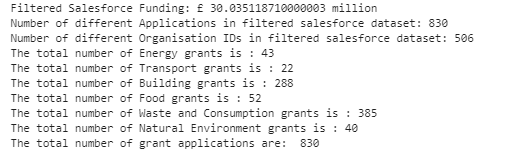

## Sub-categories to tag
<br>

Transport: 
1. Electric Vehicles (EV)
2. Innovative First/Last Mile Delivery
3. Active travel 
4. Public transport
5. Community transport (shared transport)

Buildings:
1. Energy efficiency (homes)
2. Energy efficiency (community buildings)
3. Provision of Housing

Energy: 
1. Energy generation & Storage
2. Energy Advice and education
3. Energy Finance

Food: 
1. Community food growing
2. Diet and Education
3. Community food provision
4. Farming (community owned / supported) 

Waste & Consumption 
1. Food Waste 
2. Repair and re-use
3. Retail & consumerism 
4. Waste streams 

Natural Environment
1. Land use and biodiversity conservation
2. Natural World 

In [21]:
drop_tag = ['18 characters Org ID', 'Organisational Legal Structure','If Legal Structure Other, specify', 'Year of Incorporation', 
            'Status', 'Funding Information', 'IMD Average','Total Grants Awarded', 'Total Value of Capacity Support Received']
drop_other = ['Primary Sector - App', 'Primary Impact Area', 'Secondary Impact Area', 'Charitable purpose (if other)', 'Region', 'First Award Date']

#### Energy tagging

In [22]:
df_energy = df_filtered.drop(drop_tag, axis = 1) #remove annoying columns
def tagging_datasets(df_new, drop, primary, secondary, category):
    """
    This function cleans and filters the datasets so they can be quickly tagged in excel
    """
    df_new = df_new[primary == category]
    secondary = df_new.apply(lambda x: str(x['Primary Sector - App']).replace('nan', str(x['Secondary Sector - Org'])), axis=1)
    df_new['Impact'] = df_new['Primary Impact Area'] + df_new['Secondary Impact Area'] 
    df_new = df_new.drop(drop, axis = 1)
    return(df_new)    

df_energy = tagging_datasets(df_new = df_energy, drop = drop_other, primary = df_energy['Primary Sector - Org'], secondary = df_energy['Secondary Sector - Org'], 
                 category = "Energy")
df_energy.head(2)

########Saving the file to an xlsx
df_energy['sub-category'] = ""
df_energy.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/energy.xlsx', index = False)


<ipython-input-22-732289023ec2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Impact'] = df_new['Primary Impact Area'] + df_new['Secondary Impact Area']


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/44792/Documents/Future Energy Associates/PtC/energy.xlsx'

#### Transport tagging

In [ ]:
df_transport = df_filtered.drop(drop_tag, axis = 1) #remove annoying columns
df_transport = tagging_datasets(df_new = df_transport, drop = drop_other, primary = df_transport['Primary Sector - Org'], secondary = df_transport['Secondary Sector - Org'], 
                 category = "Transport")
df_transport.head(3)

########Saving the file to an xlsx
#df_transport['sub-category'] = ""
#df_transport.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/transport.xlsx', index = False)

#### Natural Environment Tagging

In [24]:
df_natural_environment = df_filtered.drop(drop_tag, axis = 1) #remove annoying columns
df_natural_environment = tagging_datasets(df_new = df_natural_environment, drop = drop_other, primary = df_natural_environment['Primary Sector - Org'], secondary = df_natural_environment['Secondary Sector - Org'], 
                 category = "Natural Environment")
df_natural_environment.head(2)
########Saving the file to an xlsx
df_natural_environment['sub-category'] = ""
#df_natural_environment.to_excel('C:/Users/44792/Documents/FEA/PtC/natural_environment.xlsx', index = False)

<ipython-input-22-732289023ec2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Impact'] = df_new['Primary Impact Area'] + df_new['Secondary Impact Area']


#### Food tagging

In [25]:
df_food = df_filtered.drop(drop_tag, axis = 1) #remove annoying columns
df_food = tagging_datasets(df_new = df_food, drop = drop_other, primary = df_food['Primary Sector - Org'], secondary = df_food['Secondary Sector - Org'], 
                 category = "Food")
df_food.head(2)
########Saving the file to an xlsx
#df_food['sub-category'] = ""
#df_food.to_excel('C:/Users/44792/Documents/FEA/PtC/food.xlsx', index = False)

<ipython-input-22-732289023ec2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Impact'] = df_new['Primary Impact Area'] + df_new['Secondary Impact Area']


,App ID,Programme,Organisation Name,Application Name,Primary Sector - Org,Secondary Sector - Org,Charitable Purpose,Primary Sector (Other) - App,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Impact
187,APP-12155,Covid-19 Renewal Initiative,Fordhall Community Land Initiative,Renewal - Fordhall Community Land Initiative,Food,Conservation of the environment;Food catering ...,Environmental protection or improvement; Youth...,NaN,"Fordhall Organic Farm, in Market Drayton, nort...",NaN,NaN,NaN,NaN
317,APP-02929,Bright Ideas (BI),Kirkstall Valley Development Trust,Kirkstall Valley Development Trust (BI),Food,"Business or Workspace; Community Centre Hub, F...","Advancement of education, training or retraini...",NaN,KVDT was set up to develop community assets fo...,The Trust has three business strands that will...,NaN,NaN,Greater community pride and empowermentImprove...


#### Building tagging

In [26]:
df_buildings = df_filtered.drop(drop_tag, axis = 1) 
df_buildings = tagging_datasets(df_new = df_buildings, drop = drop_other, primary = df_buildings['Primary Sector - Org'], secondary = df_buildings['Secondary Sector - Org'], 
                 category = "Buildings")
df_buildings.head(3)

<ipython-input-22-732289023ec2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Impact'] = df_new['Primary Impact Area'] + df_new['Secondary Impact Area']


,App ID,Programme,Organisation Name,Application Name,Primary Sector - Org,Secondary Sector - Org,Charitable Purpose,Primary Sector (Other) - App,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Impact
12,APP-09028,COVID-19 Community Led Organisation Recovery S...,Highway Hope,C-19 CCLORS - Highway Hope,Buildings,Community café;Community shop;Education support,"Advancement of education, training or retraini...",NaN,Highway Hope is a social enterprise aims to em...,NaN,Highway Hope is a social enterprise aims to em...,This funding is intended to cover the essentia...,NaN
38,APP-09063,COVID-19 Community Led Organisation Recovery S...,Westfield Community Development Association,C-19 CCLORS - Westfield Community Development ...,Buildings,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,APP-09071,COVID-19 Community Led Organisation Recovery S...,North Smethwick Development Trust,C-19 CCLORS - North Smethwick Development Trust,Buildings,Community café,Citizenship or community development; Preventi...,NaN,"economic welfare of local people, using an ind...",NaN,"economic welfare of local people, using an ind...",- We want to use some of the funding to improv...,NaN


In [27]:
covid_funds = ['COVID-19 Community Led Organisation Recovery Scheme (CCLORS)', 'Covid-19 Renewal Initiative', 'C-19 Emergency Trading Income Support Scheme (TISS)']

def tagged_cat(fund_list, dataframe, array, tag_name):
    
    """This function allows for the quick tagging by Programme Type
    fund_list shoudl be a list, tag_name should be a string, array is the array that we want to check key words in
    Then it prints the number of covid relatated """
    
    
    if 'sub-category' in dataframe.columns:
        print("column already exists")
    else:
        dataframe['sub-category'] = ""
           
    for i in fund_list:
        dataframe.loc[array == i, ['sub-category']] = tag_name
        
    print("Number of", tag_name, "programmes:", len(dataframe[dataframe['sub-category'] == tag_name]))
  
tagged_cat(fund_list = covid_funds, dataframe = df_buildings, array = df_buildings.Programme  ,tag_name ='covid-19')

Number of covid-19 programmes: 122


In [28]:
covid_buildings = df_buildings[df_buildings['sub-category'] == "covid-19"]
non_covid_buildings = df_buildings[df_buildings['sub-category'] != "covid-19"]

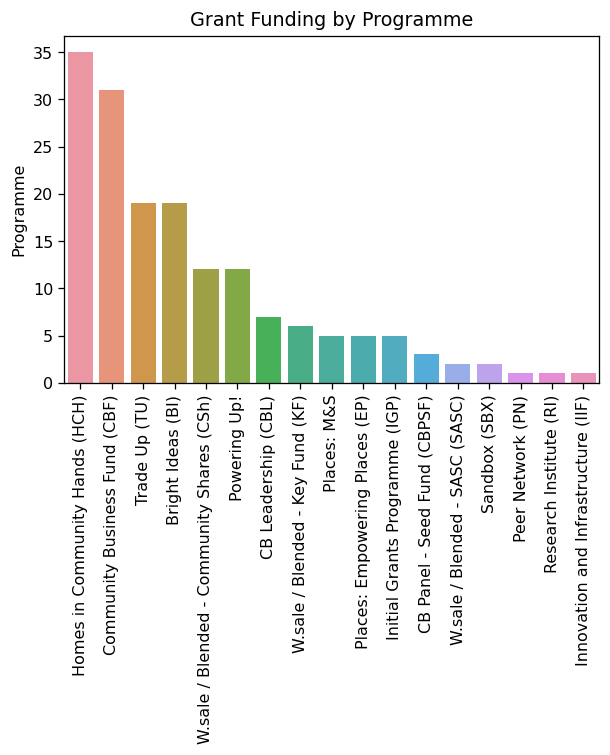

In [319]:
#if non_covid_buildings['Secondary Sector - Org'].value_counts() > 2:
#    non_covid_buildings['Secondary Sector - Org'].value_counts().plot.bar()

#p =sns.barplot(x=non_covid_buildings["Programme"].value_counts().index, y=non_covid_buildings["Programme"].value_counts())
#plt.title("Grant Funding by Programme")
#for item in p.get_xticklabels():
#    item.set_rotation(90)
#plt.show()

In [404]:
covid_buildings.to_excel('C:/Users/44792/Documents/FEA/PtC/covid_buildings.xlsx', index = False)
non_covid_buildings.to_excel('C:/Users/44792/Documents/FEA/PtC/non_covid_buildings.xlsx', index = False)

### Waste and Consumption tagging

In [29]:
df_waste_consumption = df_filtered.drop(drop_tag, axis = 1) #remove annoying columns
df_waste_consumption = tagging_datasets(df_new = df_waste_consumption, drop = drop_other, primary = df_waste_consumption['Primary Sector - Org'], secondary = df_waste_consumption['Secondary Sector - Org'], 
                 category = "Waste and Consumption")

pubs_grant_programmes = ["More Than a Pub (MTP)", "More Than a Pub 2 (MTAP2)"]
tagged_cat(fund_list = covid_funds, dataframe = df_waste_consumption, array = df_waste_consumption.Programme, tag_name = "covid-19")
tagged_cat(fund_list = pubs_grant_programmes, dataframe = df_waste_consumption, array = df_waste_consumption.Programme, tag_name = "Pubs")
df_waste_consumption.head(3)

Number of covid-19 programmes: 58
column already exists
Number of Pubs programmes: 220


<ipython-input-22-732289023ec2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Impact'] = df_new['Primary Impact Area'] + df_new['Secondary Impact Area']


,App ID,Programme,Organisation Name,Application Name,Primary Sector - Org,Secondary Sector - Org,Charitable Purpose,Primary Sector (Other) - App,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Impact,sub-category
1,APP-01620,W.sale / Blended - Key Fund (KF),Riccall Regen 2000 Ltd,Riccall Regen 2000 (KF),Waste and Consumption,"Community Pub, Shop or Café","Citizenship or community development; Youth, a...",NaN,Community hub comprising of children's nursery...,To assist with capital costs of various refurb...,NaN,NaN,Better access to servicesReduced social isolation,
10,APP-09022,COVID-19 Community Led Organisation Recovery S...,91 Ways to Build A Global City,C-19 CCLORS - 91 Ways to Build A Global City,Waste and Consumption,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,covid-19
112,APP-09801,COVID-19 Community Led Organisation Recovery S...,Leicester Community Benefit Society,C-19 CCLORS - Leicester Community Benefit Society,Waste and Consumption,"Community shop, employability skills, food bank",Assisting socially or economically excluded to...,"Community shop, employability skills, food bank",Our organisation exist to support our members ...,NaN,Our organisation exist to support our members ...,We will be using the funding to purchase addit...,NaN,covid-19


In [ ]:
#df_waste_consumption.to_excel('C:/Users/44792/Documents/FEA/PtC/df_waste_consumption.xlsx', index = False)

### Merge tagged datasets
Merge the datasets with the filtered dataset by ["App ID"]

In [30]:
df_food_tagged = pd.read_excel('food_1.xlsx')
df_natural_environment_tagged = pd.read_excel('natural_environment_1.xlsx')
df_energy_tagged = pd.read_excel('energy_1.xlsx')
df_transport_tagged = pd.read_excel('transport_1.xlsx')
df_waste_consumption_tagged = pd.read_excel('df_waste_consumption_1.xlsx')
df_non_covid_buildings_tagged = pd.read_excel('non_covid_buildings_1.xlsx')
df_covid_buildings_tagged = pd.read_excel('covid_buildings.xlsx')

In [31]:
## Step 1 join all tagged datasets
frames = [df_food_tagged, df_natural_environment_tagged, df_energy_tagged, df_transport_tagged, df_waste_consumption_tagged,
          df_non_covid_buildings_tagged, df_covid_buildings_tagged]
result = pd.concat(frames)
result = result[['App ID','sub-category']]
result

,App ID,sub-category
0,APP-12155,Farming (community owned / supported)
1,APP-02929,Natural world
2,APP-01634,NaN
3,APP-03004,Farming (community owned / supported)
4,APP-02154,Food waste
...,...,...
117,APP-08232,covid-19
118,APP-07892,covid-19
119,APP-07742,covid-19
120,APP-08204,covid-19


In [32]:
## Setp 2 join tagged datasets to filtered datasets
df_filtered.reset_index(drop=True, inplace=True)
result.reset_index(drop=True, inplace=True)
tagged = pd.merge(df_filtered, result, on='App ID')
#tagged.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/tagged.xlsx', index = False)
df_tagged = tagged

In [33]:
print("Filtered Salesforce Funding: £", df_tagged['Total Grants Awarded'].sum()/1000000, "million")
print("Number of different Applications in filtered salesforce dataset:", len(df_tagged["App ID"].unique()))
print("Number of different Organisation IDs in filtered salesforce dataset:", len(df_tagged["18 characters Org ID"].unique()))
print("The total number of Energy grants is :", len(df_tagged[df_tagged['Primary Sector - Org'] == "Energy"]))
print("The total number of Transport grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Transport"]))
print("The total number of Building grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Buildings"]))
print("The total number of Food grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Food"]))
print("The total number of Waste and Consumption grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Waste and Consumption"]))
print("The total number of Natural Environment grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Natural Environment"]))
print("The total number of grant applications are: ", len(df_tagged.index))

Filtered Salesforce Funding: £ 30.27360671 million
Number of different Applications in filtered salesforce dataset: 833
Number of different Organisation IDs in filtered salesforce dataset: 508
The total number of Energy grants is : 45
The total number of Transport grants is : 22
The total number of Building grants is : 288
The total number of Food grants is : 52
The total number of Waste and Consumption grants is : 385
The total number of Natural Environment grants is : 41
The total number of grant applications are:  833


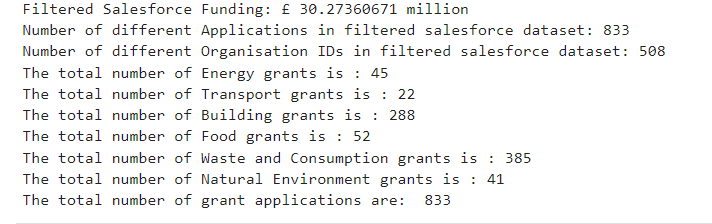

In [34]:
untagged_filtered = df_tagged[df_tagged['sub-category'].isna()] ## What is the untagged_filtered dataset?  These applications do not have enough information to tag accurately
df_tagged = df_tagged[df_tagged['sub-category'].notnull()] 
#for col in df_tagged.columns:
#   print(col)

In [36]:
untagged_filtered['sub-category']

1      NaN
23     NaN
36     NaN
38     NaN
40     NaN
      ... 
810    NaN
815    NaN
816    NaN
818    NaN
831    NaN
Name: sub-category, Length: 123, dtype: object

In [37]:
print("Filtered Salesforce Funding: £", df_tagged['Total Grants Awarded'].sum()/1000000, "million")
print("Number of different Applications in filtered salesforce dataset:", len(df_tagged["App ID"].unique()))
print("Number of different Organisation IDs in filtered salesforce dataset:", len(df_tagged["18 characters Org ID"].unique()))
print("The total number of Energy grants is :", len(df_tagged[df_tagged['Primary Sector - Org'] == "Energy"]))
print("The total number of Transport grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Transport"]))
print("The total number of Building grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Buildings"]))
print("The total number of Food grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Food"]))
print("The total number of Waste and Consumption grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Waste and Consumption"]))
print("The total number of Natural Environment grants is :",len(df_tagged[df_tagged['Primary Sector - Org'] == "Natural Environment"]))
print("The total number of grant applications are: ", len(df_tagged.index))

Filtered Salesforce Funding: £ 23.844426369999997 million
Number of different Applications in filtered salesforce dataset: 710
Number of different Organisation IDs in filtered salesforce dataset: 461
The total number of Energy grants is : 45
The total number of Transport grants is : 19
The total number of Building grants is : 230
The total number of Food grants is : 46
The total number of Waste and Consumption grants is : 334
The total number of Natural Environment grants is : 36
The total number of grant applications are:  710


In [38]:
dictionary_subcategory = {
    "Electric Vehicles" : ['Electric Vehicles', 'Electric vehicles (EV)'],
    "Innovative First/Last Mile Delivery" :  ['Innovative First/Last Mile Delivery','Provision of Housing',  'Construction Activities', 'Construction activities', 'Housing, Employment, training', 'business support or education'
                   'Shop', 'Community Space Hub or Centre'],
    "Active Travel" : ["Active Transport", "Active travel"],
    "Community Transport" : ['Community transport', 'Community transport', "Community transport ",
                             "Community transport (shared transport) / Active Transport / Retail & consumerism"],
    "Energy Efficiency (residential)" : ['Energy efficiency (homes)', "Energy efficiency (homes)*"], 
    "Energy Efficiency (community buildings)": ["Energy efficiency (community buildings)", "Energy efficiency (homes) / Energy efficiency (community buildings)"],
    "Energy Generation & Storage" : ["Energy generation", "Energy generation ", "Energy generation *", "Energy generation / Energy Storage", 
                                     "Energy infrastructure", "Energy storage", "Energy generation / Energy Storage ", "Energy generation / Energy Storage",
                                    "Energy generation / Energy efficiency (homes)"],
    "Energy Advice & Education" : ["Energy Advice and education", "Energy advice and education", "Energy advice and education *", 
                                   "Energy advice and education *", "Energy advice and education * ",
                                  "Energy advice and educaiton", "Energy advice and educaiton "],
    "Energy Finance" : ["Energy finance", "Energy finance *"],
    "Community Food Growing" : ["Community food growing", "Community food growing *"],
    "Diet & Education" : ["Diet and Education", "Diet and education"],
    "Food Provision": ["Food Provision", "Food provision", "Community food provision", "Food financing "
                       , "Food provision / Diet and education"],
    "Farming (Community Owned / Supported)" : ["Farming (community owned / supported)"],
    "Food Waste" : ["Food waste"],
    "Repair & Re-use" : ["Repair & re-use", "Repair cafes, re-use shops"],
    "Retail & Consumerism" : ["Retail & consumerism"],
    "Waste Streams" : ["Waste Streams", "Waste streams", "Waste streams ", "Repair & re-use / Waste streams", "Waste Streams  ", "Waste Streams "], 
    "Land use & biodiversity conservation" : ["Land use and biodiversity conservation"],
    "Natural World " : ["Natural world"]
}

dictionary_subcategory_1 = {keys: old_keys for old_keys, old_values in dictionary_subcategory.items() for keys in old_values}
df_tagged['sub-category'] = df_tagged['sub-category'].replace(dictionary_subcategory_1)
#df_tagged.groupby('sub-category').count()

<ipython-input-38-abafacc06802>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tagged['sub-category'] = df_tagged['sub-category'].replace(dictionary_subcategory_1)


In [41]:
#Delete Regeneration*, Urban environment, Community buildings, NA
df_tagged_pubs_others = df_tagged[(df_tagged['sub-category'] == "Regeneration *") | (df_tagged['sub-category'] == "Community buildings") | (df_tagged['sub-category'] == 'Urban environment') | (df_tagged['sub-category'] == 'Regeneration *')
                                 | (df_tagged['sub-category'] == "Pubs")]
df_tagged_final = df_tagged[(df_tagged['sub-category'] != "Regeneration *") & (df_tagged['sub-category'] != "Community buildings") & (df_tagged['sub-category'] != 'Urban environment') & (df_tagged['sub-category'] != 'Regeneration *')
                       & (df_tagged['sub-category'] != "Pubs") & (df_tagged['sub-category'] != "NA  ")]
df_tagged_covid_only = df_tagged[df_tagged['sub-category'] == 'covid-19']
other_test = df_tagged[df_tagged['sub-category'] == "NA  "]
df_tagged_non_covid = df_tagged_final[df_tagged_final['sub-category'] != 'covid-19']

In [42]:
print("Initial Dataset :", len(df_tagged.index))
print("The total number of removed Pubs/other buildings grants are :", len(df_tagged_pubs_others.index))
print("The total final grants :", len(df_tagged_final.index))
print("Additional NAs removed :", len(other_test.index))

#print("The total number of grant applications are: ", len(df_filtered.index))

Initial Dataset : 710
The total number of removed Pubs/other buildings grants are : 246
The total final grants : 462
Additional NAs removed : 2


In [43]:
## Repalce main categories based on sub-categories:
dictionary_main_category = {
    "Transport" : ['Electric Vehicles', 'Innovative First/Last Mile Delivery', 'Active Travel', 'Community Transport',
                   "Community transport (shared transport) / Active Transport / Retail & consumerism", 'Innovative First/Last Mile Delivery '],
    "Buildings" :  ['Energy Efficiency (residential)','Provision of Housing',  'Energy Efficiency (community buildings)',
                    "Energy efficiency (homes) / Energy efficiency (community buildings)", 'Provision of housing'],
    "Energy" : ["Energy Generation & Storage", "Energy Advice & Education", 'Energy Finance', "Energy generation / Energy efficiency (homes)"],
    "Food" : ["Community Food Growing", "Diet & Education", "Food Provision", "Farming (Community Owned / Supported)", 
              "Food provision / Diet and education"],
    "Waste and Consumption" : ["Food Waste", "Repair & Re-use", "Retail & Consumerism", "Waste Streams", "Repair & re-use / Waste streams", "Waste Streams  ", "Waste Streams "],
    "Natural Environment" : ["Natural World", "Land use & biodiversity conservation", "Natural World "]
}

df_tagged_final['main_category'] = df_tagged_final['sub-category']
dictionary_main_category_rev = {keys: old_keys for old_keys, old_values in dictionary_main_category.items() for keys in old_values}
df_tagged_final['main_category'] = df_tagged_final['main_category'].replace(dictionary_main_category_rev)
df_tagged_final["main_category"] = np.where(df_tagged_final["sub-category"] == "covid-19", df_tagged_final["Primary Sector - Org"], df_tagged_final['main_category'])
df_tagged_final['Region'] = np.where(df_tagged_final['Region'] == 'London', "Greater London", df_tagged_final['Region']) 

<ipython-input-43-ae3f8642eefa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tagged_final['main_category'] = df_tagged_final['sub-category']
<ipython-input-43-ae3f8642eefa>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tagged_final['main_category'] = df_tagged_final['main_category'].replace(dictionary_main_category_rev)
<ipython-input-43-ae3f8642eefa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [40]:
#Delete Regeneration*, Urban environment, Community buildings, NA
df_tagged_pubs_others = df_tagged[(df_tagged['sub-category'] == "Regeneration *") | (df_tagged['sub-category'] == "Community buildings") | (df_tagged['sub-category'] == 'Urban environment') | (df_tagged['sub-category'] == 'Regeneration *')
                                 | (df_tagged['sub-category'] == "Pubs")]
df_tagged_final = df_tagged[(df_tagged['sub-category'] != "Regeneration *") & (df_tagged['sub-category'] != "Community buildings") & (df_tagged['sub-category'] != 'Urban environment') & (df_tagged['sub-category'] != 'Regeneration *')
                       & (df_tagged['sub-category'] != "Pubs") & (df_tagged['sub-category'] != "NA  ")]
df_tagged_covid_only = df_tagged[df_tagged['sub-category'] == 'covid-19']
other_test = df_tagged[df_tagged['sub-category'] == "NA  "]
df_tagged_non_covid = df_tagged_final[df_tagged_final['sub-category'] != 'covid-19']

In [47]:
df_tagged_c19_only = df_tagged_final[df_tagged_final['sub-category'] == 'covid-19']
print("covid only length", len(df_tagged_c19_only))
print("covid only pre", len(df_tagged_covid_only))
print("non covid", len(df_tagged_non_covid))

covid only length 181
covid only pre 181
non covid 281


In [44]:
print("Cumulative funding incl. pubs, urban environmnet, regeneration = £", df_tagged['Total Grants Awarded'].sum()/1000000, "million ")
print("Cumulative funding of tagged relevant grants (incl. Covid) = £", df_tagged_final['Total Grants Awarded'].sum()/1000000, "million ")
print("Cumulative funding of tagged relevant grants (excl. Covid) = £", df_tagged_non_covid['Total Grants Awarded'].sum()/1000000, "million ")

Cumulative funding incl. pubs, urban environmnet, regeneration = £ 23.844426369999997 million 
Cumulative funding of tagged relevant grants (incl. Covid) = £ 18.28372606 million 
Cumulative funding of tagged relevant grants (excl. Covid) = £ 14.671181059999999 million 


In [77]:
#df_tagged_covid_only.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/tagged_covid_only.xlsx', index = False)
#df_tagged_pubs_others.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/tagged_pubs_others.xlsx', index = False)
#df_tagged_final.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/df_tagged_final.xlsx', index = False)
#df_tagged.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/df_tagged_incl.everything.xlsx', index = False)
df_tagged_non_covid.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/df_tagged_final_non_covid.xlsx', index = False)
#untagged_filtered.to_excel('C:/Users/44792/Documents/Future Energy Associates/PtC/untagged_filtered.xlsx')

### Exploratory Data Analysis
1. Funding overtime (Inidividually and cumualatively) 
2. Funding by region 
3. Funding by deprivation
4. Funding by main category 
5. Funding by sub category 

In [53]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
mpl.rcParams['figure.dpi'] = 115

In [54]:
df_tagged_final = df_tagged_final.sort_values(by = ['First Award Date'], ascending = False)
df_tagged_final = df_tagged_final[df_tagged_final['App ID'] != 'APP-11909'] ## Outlier - Possible recording error
df_tagged_final = df_tagged_final.sort_values(by = ['Total Grants Awarded'], ascending = False)

#df_tagged_final
#1 APP-00059 "Develop affordable, sustainable community housing" Buildings
#2 APP-04814 "Incentize active transport by providing bike libraries" Transport
#3 APP-01695 "Community owned farm: Focus on increasing awarness of food and farming and changing consumption behaviour" FOOD
#4 APP-02388 "Create sustainable energy efficient future for Bramley Baths" Buildings

In [60]:
test = df_tagged_final
test.loc[test["sub-category"] == "covid-19", 'main_category'] = 'covid-19'
test

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information,sub-category,main_category
269,0012400000RRabDAAT,APP-00059,Initial Grants Programme (IGP),Granby 4 Streets Community Land Trust,Granby Four Streets Community Land Trust Limit...,Community Benefit Society,Industrial Provident Society,2011.0,Buildings,"Business or workspace;Employment, Training, Bu...",...,391402.0,0.00,2015-09-23,Granby Four Streets Community Land Trust wants...,NaN,NaN,NaN,NaN,Energy Efficiency (residential),Buildings
49,0012400000RRaNpAAL,APP-04814,Community Business Fund (CBF),Bradford Trident,Bradford Trident Limited (CBF),Charitable Company Limited by Guarantee,NaN,2000.0,Buildings,Community café,...,308000.0,0.00,2019-10-15,"To engage, inspire and enable people to work t...",Putting a spring in the step of Parkside Sport...,NaN,NaN,NaN,Active Travel,Transport
367,0012400000RRaZXAA1,APP-01695,Community Business Fund (CBF),Fordhall Community Land Initiative,Fordhall Community Land Initiative (CBF),Community Benefit Society,NaN,2005.0,Food,Conservation of the environment;Food catering ...,...,307725.0,0.00,2017-08-05,"Fordhall Organic Farm, in Market Drayton, nort...",Fordhall Community Land Initiative (FCLI) is c...,NaN,NaN,NaN,Farming (Community Owned / Supported),Food
291,0011p00001vFrSlAAK,APP-02388,Community Business Fund (CBF),Bramley Baths and Community Ltd,Bramley Baths and Community Ltd (CBF),Community Benefit Society,NaN,NaN,Energy,"Community space, hub or centre;Conservation of...",...,303000.0,0.00,2018-09-17,"Bramley Baths is a community-led, not for prof...",Bramley Baths Energy Hub ? Introducing new tec...,NaN,NaN,NaN,Energy Efficiency (community buildings),Buildings
47,0011p00002Y7SZoAAN,APP-04861,Community Business Fund (CBF),Leeds Action to Create Homes Limited,Leeds Action to Create Homes Limited (CBF),Community Benefit Society,NaN,NaN,Buildings,"Employment, Training, Business, or Education S...",...,302251.0,0.00,2019-10-16,Latch is an innovative community-based housing...,?Latch Creates? a sustainability project creat...,NaN,NaN,NaN,Provision of housing,Buildings
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0012400000RRaeeAAD,APP-01639,CB Leadership (CBL),Incredible Farm,Incredible Farm (CBL),Other,Private company limited by guarantee without s...,NaN,Natural Environment,Arts centre or activities;Conservation of the ...,...,0.0,5764.60,NaT,11/6/215 SM to CO: Strongly volunteer lead and...,NaN,NaN,NaN,NaN,Natural World,Natural Environment
128,00124000019nH4UAAU,APP-01642,CB Leadership (CBL),Sow the City CIC,Sow the City Limited (CBL),Community Interest Company Limited by Guarantee,NaN,2009.0,Buildings,NaN,...,0.0,5764.60,NaT,We want to build a healthier city where everyo...,NaN,NaN,NaN,NaN,Community Food Growing,Food
134,00124000011QJcQAAW,APP-11998,Covid-19 Renewal Initiative,North Smethwick Development Trust,Renewal - North Smethwick Development Trust,Charitable Incorporated Organisation,Company limited by guarantee,1992.0,Buildings,Community café,...,0.0,0.00,NaT,"economic welfare of local people, using an ind...",NaN,NaN,NaN,Grant Requirements What do you intend to use t...,covid-19,covid-19
135,0011p00002hstqzAAA,APP-11987,Covid-19 Renewal Initiative,Cardigan Centre,Renewal - Cardigan Centre,Charitable Incorporated Organisation,NaN,1991.0,Buildings,NaN,...,0.0,0.00,NaT,NaN,NaN,NaN,NaN,Grant Requirements What do you intend to use t...,covid-19,covid-19


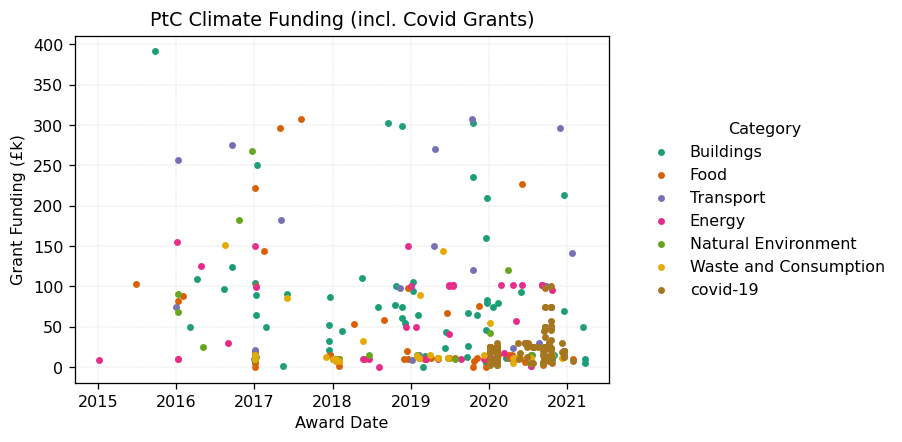

In [70]:
fig, ax = plt.subplots(1,1)

#Get the unique names of main categories
#main_cats = list(set(test['main_category']))
main_cats = ['Buildings', "Food", "Transport", "Energy", "Natural Environment", "Waste and Consumption", "covid-19"]
#food = orange, transprot = blue, energy pink, ne = green, waste & consumption = yellow

#Scatter the Petal 
x = test['First Award Date']
y = (test['Total Grants Awarded'])/1000

#Set the colour map to match the number of species
z = range(1,len(main_cats))
colours_selected = plt.get_cmap('Dark2')
cNorm  = colors.Normalize(vmin=0, vmax=len(main_cats))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colours_selected)

for i in range(len(main_cats)):
    indx = test['main_category'] == main_cats[i]
    ax.scatter(x[indx], y[indx], s=11, color=scalarMap.to_rgba(i), label=main_cats[i])

    
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", title = "Category", framealpha = 0)
ax.grid(linestyle='dotted', linewidth = .3)
ax.set(title= "PtC Climate Funding (incl. Covid Grants)", xlabel = "Award Date", ylabel = "Grant Funding (£k)")
plt.savefig('PtC_Climate_Funding_Scatter.png', dpi=150, bbox_inches='tight')
plt.show()

### Plots for Location

In [45]:
df_tagged_final_location = df_tagged_final

In [46]:
### Data error replace London with Greater London
df_tagged_final_location["Total Grants Awarded"] = df_tagged_final_location["Total Grants Awarded"]/1000
df_tagged_final_location.head(3)

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information,sub-category,main_category,Climate Relevance
0,0011p000021ty1wAAA,APP-04653,Next Generation Community Energy (NGCE),Yealm Community Energy,Creacombe Project Development (NGCE),Community Benefit Society,NaN,NaN,Energy,NaN,...,0.0,2019-06-30,NaN,The following tasks have been identified for w...,NaN,NaN,NaN,Energy Generation & Storage,Energy,High
1,00124000018h524AAA,APP-01619,W.sale / Blended - SASC (SASC),Gawcott Fields Community Solar Project C.I.C.,Gawcott Fields Community Solar Project C.I.C. ...,Community Interest Company Limited by Shares,NaN,NaN,Energy,NaN,...,0.0,2017-01-03,Gawcott Fields Community Solar (GFCS) is a com...,Gawcott Fields Community Solar (GFCS) is a com...,NaN,NaN,NaN,Energy Generation & Storage,Energy,High
2,0011p00001hwU7ZAAU,APP-09022,COVID-19 Community Led Organisation Recovery S...,91 Ways to Build A Global City,C-19 CCLORS - 91 Ways to Build A Global City,NaN,NaN,NaN,Waste and Consumption,NaN,...,0.0,2020-09-15,NaN,NaN,NaN,NaN,NaN,covid-19,Waste and Consumption,covid-19


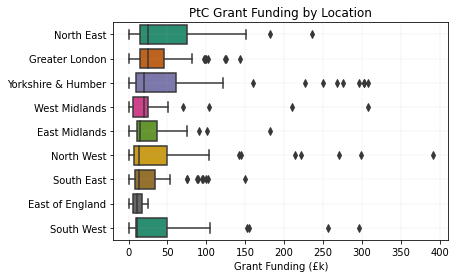

In [47]:
fig, ax = plt.subplots(1,1)
g = sns.boxplot(x="Total Grants Awarded", y="Region", palette = "Dark2", data= df_tagged_final_location,
                order = ["North East", "Greater London", "Yorkshire and Humber", "West Midlands",
                        "East Midlands", "North West", "South East", 
                         "East of England", "South West"])
(g.set_yticklabels(["North East", "Greater London", "Yorkshire & Humber", "West Midlands",
                        "East Midlands", "North West", "South East", 
                         "East of England", "South West"]))


#(g.set_yticklabels(["London", "North\nEast", "Yorkshire &\nHumber", "West\nMidlands",
#                        "East \nMidlands", "Greater\nLondon", "North\nWest", "South\nEast", 
 #                        "East of\nEngland", "South\nWest"], rotation = 90))
medians = df_tagged_final_location.groupby(['Region'])['Total Grants Awarded'].median()
ax.set(title= "PtC Grant Funding by Location", xlabel = "Grant Funding (£k)", ylabel = "")
ax.grid(linestyle='dotted', linewidth = .3)
plt.savefig('PtC_Grant_Funding_Location.png', dpi=150, bbox_inches='tight')
plt.show()

In [48]:
## Reload df_tagged_final
df_tagged_final = pd.read_excel('df_tagged_final.xlsx', parse_dates= ['First Award Date'])

In [49]:
sum_totals_loc = df_tagged_final.groupby(['Region']).sum()

In [50]:
sum_totals_loc = sum_totals_loc.reset_index(level=0)
sum_totals_loc = sum_totals_loc.drop(['Year of Incorporation', 'IMD Average', 'Total Value of Capacity Support Received'], axis = 1)
sum_totals_loc = sum_totals_loc.sort_values(by = ['Total Grants Awarded'], ascending = False)
sum_totals_loc['Total Grants Awarded'] = sum_totals_loc['Total Grants Awarded']/1000000
sum_totals_loc


,Region,Total Grants Awarded
8,Yorkshire and Humber,4.702112
4,North West,3.545395
6,South West,3.046651
2,Greater London,1.639985
5,South East,1.504095
7,West Midlands,1.244240
3,North East,1.114492
0,East Midlands,0.797704
1,East of England,0.264043


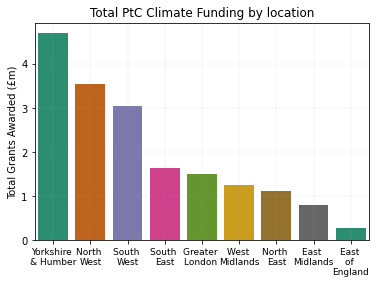

In [51]:
g = sns.barplot(x='Region', y='Total Grants Awarded', 
             palette = "Dark2", ci = None, dodge = False,
            data=sum_totals_loc)
(g.set_xticklabels(["Yorkshire \n& Humber", "North \nWest", "South \nWest", "South \nEast", "Greater \nLondon ", 
                    "West \nMidlands", "North \nEast", "East \nMidlands",  "East \nof \nEngland"]))
plt.xticks(fontsize = 9)
plt.title("Total PtC Climate Funding by location")
plt.xlabel("")
plt.ylabel("Total Grants Awarded (£m)")
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('Total_PtC_Climate_Funding_Location.png', dpi=115, bbox_inches='tight')
plt.show()

### Plots for Deprivation

In [116]:
medians = df_tagged_final.groupby(['IMD Average'])['Total Grants Awarded'].median().sort_values()
medians

IMD Average
10     7120.0
8     11315.5
5     14400.0
7     14825.0
4     14952.5
2     16600.0
6     18728.0
3     19000.0
1     20000.0
9     30000.0
0     85700.5
Name: Total Grants Awarded, dtype: float64

In [117]:
df_tagged_final_IMD = df_tagged_final
df_tagged_final_IMD["Total Grants Awarded"] = df_tagged_final_IMD["Total Grants Awarded"]/1000

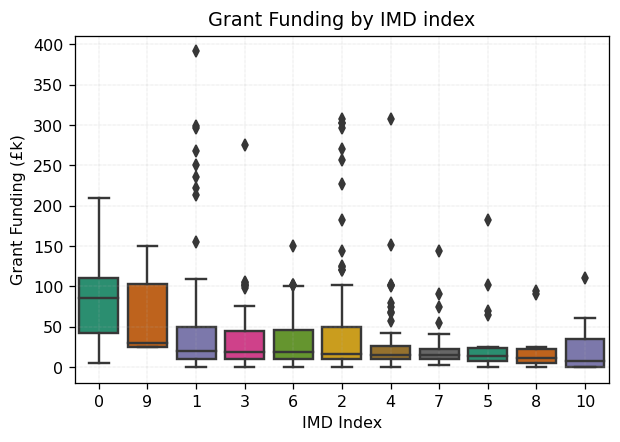

In [118]:
fig, ax = plt.subplots(1,1)
g = sns.boxplot(x="IMD Average", y="Total Grants Awarded", palette = "Dark2",
                data= df_tagged_final_IMD, order= [0, 9, 1, 3, 6, 2, 4, 7, 5, 8, 10])
ax.set(title= "Grant Funding by IMD index", xlabel = "IMD Index", ylabel = "Grant Funding (£k)")
ax.grid(linestyle='dotted', linewidth = .3)
plt.savefig('Grant_Funding_IMD_index.png', dpi=150, bbox_inches='tight')
plt.show()

In [120]:
## Reload df_tagged_final
df_tagged_final = pd.read_excel('df_tagged_final.xlsx', parse_dates= ['First Award Date'])

In [121]:
sum_totals_IMD = df_tagged_final.groupby(["IMD Average"]).sum()
sum_totals_IMD = sum_totals_IMD.reset_index(level=0)
sum_totals_IMD = sum_totals_IMD.drop(['Year of Incorporation', 'Total Value of Capacity Support Received'], axis = 1)
sum_totals_IMD = sum_totals_IMD.sort_values(by = ['Total Grants Awarded'], ascending = False)
sum_totals_IMD['Total Grants Awarded'] = sum_totals_IMD['Total Grants Awarded']/1000000
sum_totals_IMD

,IMD Average,Total Grants Awarded
1,1,5.280588
2,2,4.321856
3,3,2.011451
4,4,1.688611
0,0,1.348250
6,6,1.114225
5,5,0.921823
7,7,0.622940
8,8,0.362934
9,9,0.333000


In [122]:
for i in sum_totals_IMD['Total Grants Awarded']:
    print(i)

5.280588
4.321856
2.01145114
1.688611
1.34825
1.1142249
0.921823
0.62294002
0.362934
0.333
0.278048


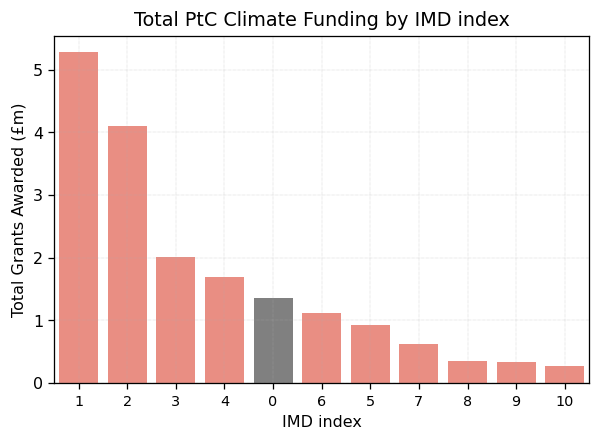

In [123]:
values = np.array([5.280588, 4.097256, 2.01145114,1.688611,1.34825,1.1142249,0.921823,0.62294002,0.349046,0.333,0.278048])
idx = np.array([1, 2, 3, 4, 0, 6, 5, 7, 8, 9, 10])
clrs = ['grey' if (x == 1.34825) else 'salmon' for x in values]

g = sns.barplot(x=idx, y=values, palette=clrs, ci = None, dodge = False, 
            data=sum_totals_IMD, order= [1, 2, 3, 4, 0, 6, 5, 7, 8, 9, 10])
#(g.set_xticklabels([1, 2, 3, 4, 0, 6, 5, 7, 8, 9, 10]))


plt.xticks(fontsize = 9)
plt.title("Total PtC Climate Funding by IMD index")
plt.xlabel("IMD index")
plt.ylabel("Total Grants Awarded (£m)")
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('Total_PtC_Climate_Funding_IMD.png', dpi=115, bbox_inches='tight')
plt.show()

## Plots For Main and Sub Category

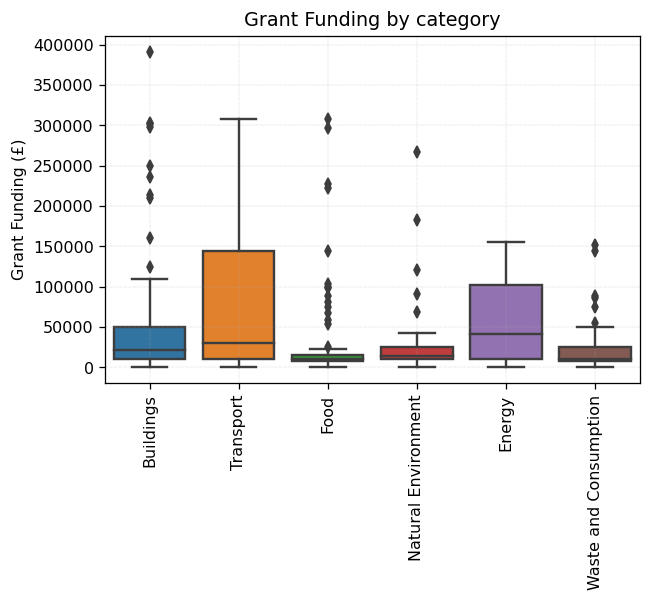

In [151]:
fig, ax = plt.subplots(1,1)
g = sns.boxplot(x="main_category", y="Total Grants Awarded",data=df_tagged_final)
ax.set(title = "Grant Funding by category", xlabel = "", ylabel = "Grant Funding (£)")
for item in g.get_xticklabels():
    item.set_rotation(90)
ax.grid(linestyle='dotted', linewidth = .3)
plt.show()

In [152]:
sum_totals = df_tagged_final.groupby(['sub-category']).sum()

In [155]:
sum_totals

,Year of Incorporation,IMD Average,Total Grants Awarded,Total Value of Capacity Support Received
sub-category,,,,
Active Travel,8022.0,23,1082748.00,0.00
Community Food Growing,16009.0,49,635248.00,19329.20
Community Transport,10001.0,48,1131345.00,0.00
Diet & Education,12030.0,82,879389.50,35984.21
Electric Vehicles,0.0,11,290045.00,7000.00
Energy Advice & Education,0.0,34,275640.00,11613.47
Energy Efficiency (community buildings),6042.0,44,1190687.00,0.00
Energy Efficiency (residential),8032.0,93,2093820.00,48300.00
Energy Finance,2010.0,20,412223.90,5065.87


In [156]:
sum_totals = sum_totals.reset_index(level=0) \
    .drop(['Year of Incorporation', 'IMD Average', 'Total Value of Capacity Support Received'], axis = 1) \
    .sort_values(by = ['Total Grants Awarded'], ascending = False)
sum_totals['Total Grants Awarded'] = sum_totals['Total Grants Awarded']/1000
sum_totals_no_covid = sum_totals[sum_totals["sub-category"] != "covid-19"]
sum_totals_no_covid['Categories'] = sum_totals_no_covid['sub-category']
dictionary_main_category_rev = {keys: old_keys for old_keys, old_values in dictionary_main_category.items() for keys in old_values}
sum_totals_no_covid['Categories'] = sum_totals_no_covid['Categories'].replace(dictionary_main_category_rev)

<ipython-input-156-45045d7bf033>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_totals_no_covid['Categories'] = sum_totals_no_covid['sub-category']
<ipython-input-156-45045d7bf033>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_totals_no_covid['Categories'] = sum_totals_no_covid['Categories'].replace(dictionary_main_category_rev)


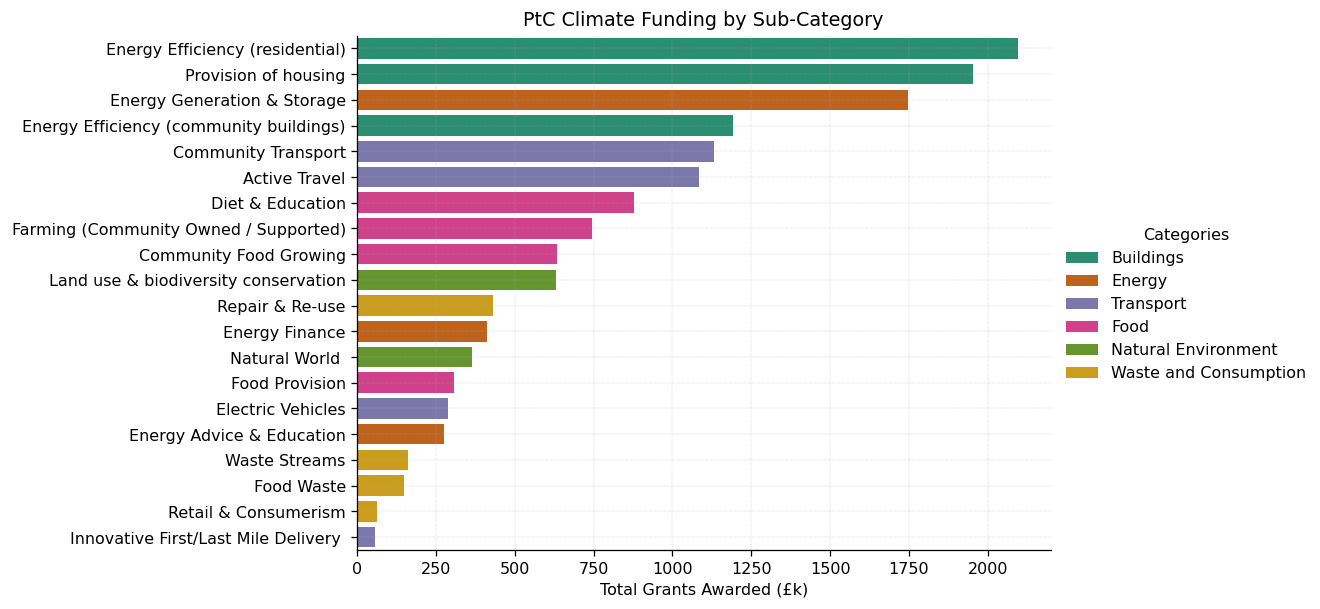

In [157]:
sns.catplot(x='Total Grants Awarded', y='sub-category', kind = "bar",
            hue = 'Categories', palette = "Dark2", ci = None, aspect = 2, dodge = False,
            data=sum_totals_no_covid)
plt.title("PtC Climate Funding by Sub-Category")
plt.xlabel("Total Grants Awarded (£k)")
plt.ylabel("")
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('PtC_Climate_Funding_by_Sub_Category.png', dpi=150, bbox_inches='tight')
plt.show()

In [158]:
sum_totals_no_covid_main_cat = sum_totals_no_covid.groupby(['Categories']).sum()
sum_totals_no_covid_main_cat = sum_totals_no_covid_main_cat.reset_index(level=0)
sum_totals_no_covid_main_cat = sum_totals_no_covid_main_cat.sort_values(by = ['Total Grants Awarded'], ascending = False)
sum_totals_no_covid_main_cat

,Categories,Total Grants Awarded
0,Buildings,5238.08600
2,Food,2568.64902
4,Transport,2560.02800
1,Energy,2436.07904
3,Natural Environment,994.03000
5,Waste and Consumption,805.66600


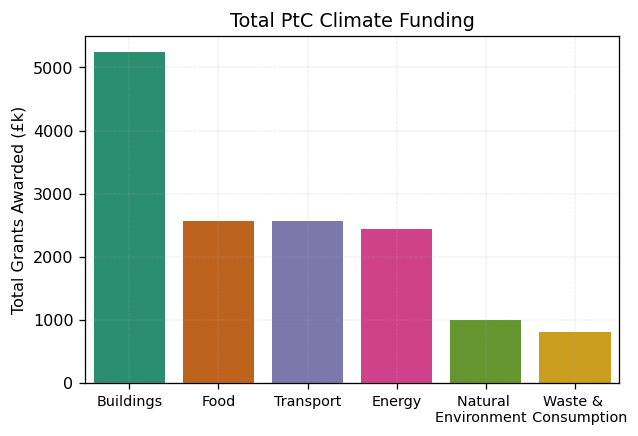

In [159]:
g = sns.barplot(x='Categories', y='Total Grants Awarded', 
             palette = "Dark2", ci = None, dodge = False,
            data=sum_totals_no_covid_main_cat)
(g.set_xticklabels(["Buildings", "Food", "Transport", "Energy", "Natural \nEnvironment  ", "Waste & \n  Consumption"]))
plt.xticks(fontsize = 9)
plt.title("Total PtC Climate Funding")
plt.xlabel("")
plt.ylabel("Total Grants Awarded (£k)")
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('Total_PtC_Climate_Funding.png', dpi=115, bbox_inches='tight')
plt.show()

## Funding Overtime

In [161]:
time = df_tagged_final.set_index('First Award Date').groupby([pd.Grouper(freq='Y'), 
                                                                  "main_category", "sub-category"]).sum()
time = time.reset_index(level=0)
time = time.drop(['Year of Incorporation', 'IMD Average', 'Total Value of Capacity Support Received'], axis = 1)
time = time.reset_index()
time['Total Grants Awarded'] = time['Total Grants Awarded']/1000

time_total = df_tagged_final.set_index('First Award Date').groupby([pd.Grouper(freq='Y')]).sum()
time_total = time_total.reset_index(level=0)
time_total = time_total.drop(['Year of Incorporation', 'IMD Average', 'Total Value of Capacity Support Received'], axis = 1)
time_total['Total Grants Awarded'] = time_total['Total Grants Awarded']/1000
time_total['main_category'] = 'Total'

time_everything = pd.concat([time, time_total]) 
#Remove 2021 and add Covid-19
time_before_2021 = time_everything[time_everything['First Award Date'] != "2021-12-31"]
time_before_2021['main_category'] = np.where(time_before_2021['sub-category'] == 'covid-19', "Covid-19", time_before_2021['main_category']) 
time_before_2021 = time_before_2021.set_index('First Award Date').groupby([pd.Grouper(freq='Y'), 
                                                                  "main_category"]).sum()
time_before_2021 = time_before_2021.reset_index(level=0)
time_before_2021 = time_before_2021.reset_index(level=0)
time_before_2021

<ipython-input-161-bd1be9672313>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_before_2021['main_category'] = np.where(time_before_2021['sub-category'] == 'covid-19', "Covid-19", time_before_2021['main_category'])


,main_category,First Award Date,Total Grants Awarded
0,Buildings,2015-12-31,391.40200
1,Energy,2015-12-31,8.75000
2,Food,2015-12-31,103.00000
3,Total,2015-12-31,503.15200
4,Buildings,2016-12-31,380.62000
5,Energy,2016-12-31,319.52500
6,Food,2016-12-31,180.03300
7,Natural Environment,2016-12-31,635.08000
8,Total,2016-12-31,2275.13300
9,Transport,2016-12-31,607.87500


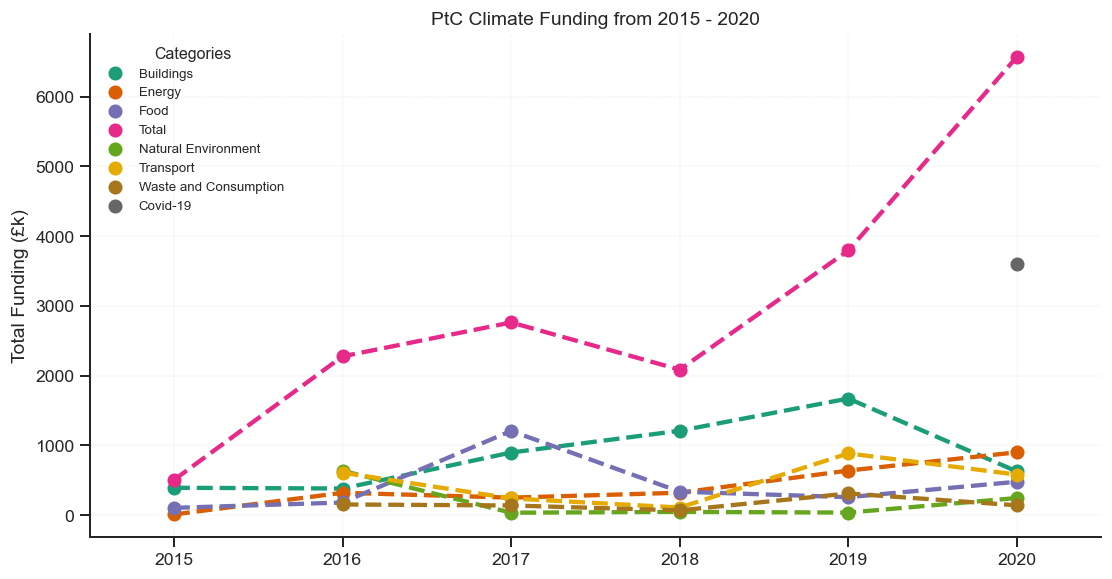

In [162]:
sns.set_theme(style="ticks")
g = sns.catplot(x='First Award Date', y='Total Grants Awarded', hue= 'main_category', palette = "Dark2", linestyles="--", 
                aspect = 2, kind = "point", ci = None, data= time_before_2021, legend = False)
(g.set_axis_labels("", "Total Funding (£k)")
    .set_xticklabels(["2015", "2016", "2017", "2018", "2019",
                      "2020"]))
plt.title("PtC Climate Funding from 2015 - 2020")
plt.legend(loc="upper left", title = "Categories", title_fontsize = "small", framealpha = 0, fontsize = 'x-small')
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('PTC_Climate_Grants_Time_Cat.png', dpi=150, bbox_inches='tight')
plt.show()

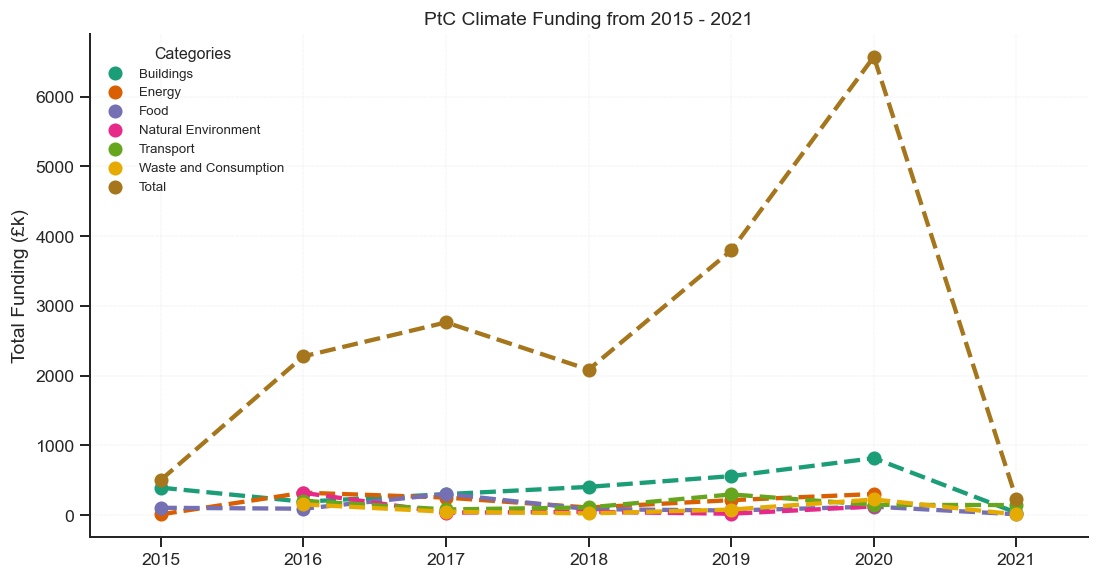

In [163]:
sns.set_theme(style="ticks")
g = sns.catplot(x='First Award Date', y='Total Grants Awarded', hue= 'main_category', palette = "Dark2", linestyles="--", 
                aspect = 2, kind = "point", ci = None, data= time_everything, legend = False)
(g.set_axis_labels("", "Total Funding (£k)")
    .set_xticklabels(["2015", "2016", "2017", "2018", "2019",
                      "2020", "2021"]))
plt.title("PtC Climate Funding from 2015 - 2021")
plt.legend(loc="upper left", title = "Categories", title_fontsize = "small", framealpha = 0, fontsize = 'x-small')
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('PTC_Climate_Grants_Time_Cat.png', dpi=150, bbox_inches='tight')
plt.show()

### Comparison with Publically available GrantNav Dataset

In [ ]:
#Notes from GrantNav dataset
#Funding Org:Name	Award Date	Amount Awarded
#20	Power to Change Trust	2015-12-31	5739.00028
#26	Power to Change Trust	2016-12-31	8483.13250
#34	Power to Change Trust	2017-12-31	10137.99055
#44	Power to Change Trust	2018-12-31	10106.50611
#54	Power to Change Trust	2019-12-31	1770.48900

In [164]:
comparison_grantnav = pd.read_csv('comparison_grantnav.csv', parse_dates = ['Award Date'])
comparison_grantnav['dataset'] = "GrantNav"
comparison_grantnav = comparison_grantnav.drop(['Funding Org:Name'], axis=1)
comparison_PtC = time_before_2021[time_before_2021['main_category'] == "Total"]
comparison_PtC['dataset'] = "PtC"
comparison_PtC = comparison_PtC.drop(['main_category'], axis = 1)
comparison_PtC = comparison_PtC.rename(columns={"First Award Date" : "Award Date", "Total Grants Awarded": "Amount Awarded"})
comparison = pd.concat([comparison_PtC, comparison_grantnav])
comparison

<ipython-input-164-672db9c79826>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_PtC['dataset'] = "PtC"


,Award Date,Amount Awarded,dataset
3,2015-12-31,503.15200,PtC
8,2016-12-31,2275.13300,PtC
15,2017-12-31,2761.78902,PtC
22,2018-12-31,2084.69200,PtC
29,2019-12-31,3794.31304,PtC
37,2020-12-31,6571.55200,PtC
0,2015-12-31,5739.00028,GrantNav
1,2016-12-31,8483.13250,GrantNav
2,2017-12-31,10137.99055,GrantNav
3,2018-12-31,10106.50611,GrantNav


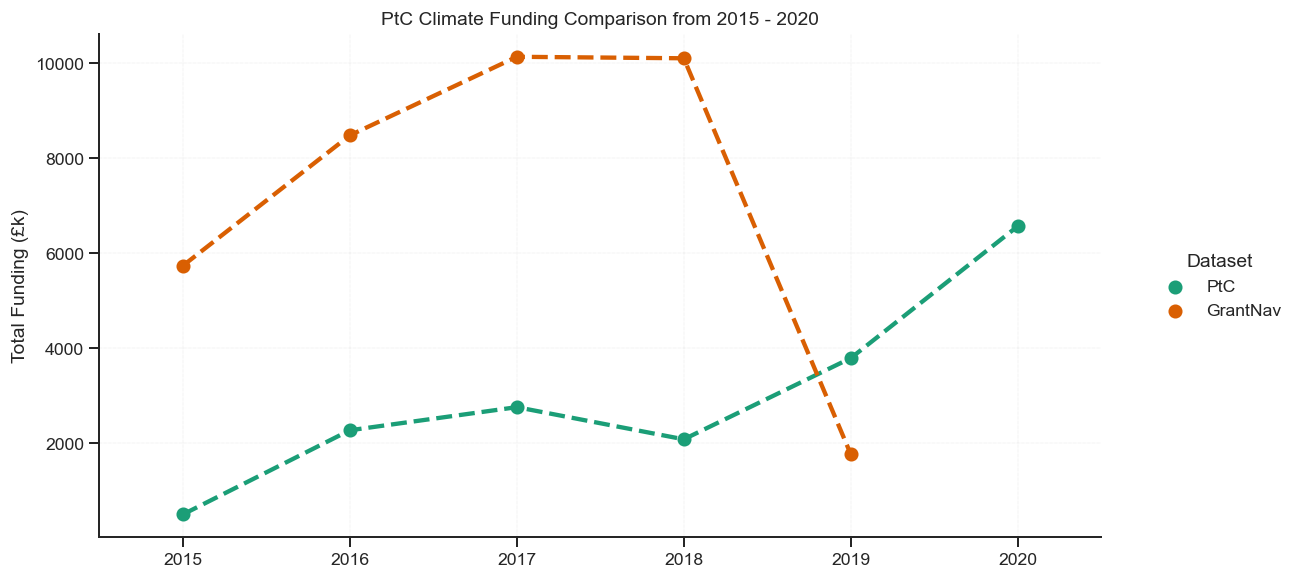

In [165]:
sns.set_theme(style="ticks")
g = sns.catplot(x='Award Date', y='Amount Awarded', hue= 'dataset', palette = "Dark2", linestyles="--", 
                aspect = 2, kind = "point", ci = None, data= comparison, legend = False)
(g.set_axis_labels("", "Total Funding (£k)")
    .set_xticklabels(["2015", "2016", "2017", "2018", "2019",
                      "2020"]))
plt.title("PtC Climate Funding Comparison from 2015 - 2020")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", title = "Dataset", framealpha = 0)
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('PTC_Climate_Grants_Comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
#### Find count of climate grants relative to total grants
1) find non-duplicate grants
2) compare to our counts

In [1]:
sum_totals_no_covid

NameError: name 'sum_totals_no_covid' is not defined

In [ ]:
sns.catplot(x='Total Grants Awarded', y='sub-category', kind = "bar",
            hue = 'Categories', palette = "Dark2", ci = None, aspect = 2, dodge = False,
            data=sum_totals_no_covid)
plt.title("PtC Climate Funding by Sub-Category")
plt.xlabel("Total Grants Awarded (£k)")
plt.ylabel("")
plt.grid(linestyle='dotted', linewidth = .3)
plt.savefig('PtC_Climate_Funding_by_Sub_Category.png', dpi=150, bbox_inches='tight')
plt.show()

## Totals by Programme Type

In [166]:
sum_totals_main_sub_cat_programme = df_tagged_final.groupby(['sub-category', 'Programme', 'main_category']).sum()

In [167]:
sum_totals_main_sub_cat_programme = sum_totals_main_sub_cat_programme.reset_index(level=0) \
    .reset_index(level=0) \
    .reset_index(level=0) \
    .drop(['Year of Incorporation','IMD Average', 'Total Value of Capacity Support Received'], axis = 1) \
    .sort_values(by = ['Total Grants Awarded'], ascending = False)

sum_totals_main_sub_cat_programme['Total Grants Awarded'] = sum_totals_main_sub_cat_programme['Total Grants Awarded']/1000

#### Group covid programmes:
covid_funds = ['COVID-19 Community Led Organisation Recovery Scheme (CCLORS)', 'Covid-19 Renewal Initiative', 'C-19 Emergency Trading Income Support Scheme (TISS)']

def tagged_cat(fund_list, dataframe, array, tag_name):
    
    """This function allows for the quick tagging by Programme Type
    fund_list shoudl be a list, tag_name should be a string, array is the array that we want to check key words in
    Then it prints the number of covid relatated """
    
               
    for i in fund_list:
        dataframe.loc[array == i, ['Programme']] = tag_name
        
  
tagged_cat(fund_list = covid_funds, dataframe = sum_totals_main_sub_cat_programme, array = sum_totals_main_sub_cat_programme.Programme  ,tag_name ='Covid-19')

sum_totals_main_sub_cat_programme


,main_category,Programme,sub-category,Total Grants Awarded
121,Buildings,Covid-19,covid-19,1308.208
119,Buildings,Covid-19,covid-19,993.630
100,Buildings,Homes in Community Hands (HCH),Provision of housing,945.991
47,Buildings,Homes in Community Hands (HCH),Energy Efficiency (residential),903.010
1,Transport,Community Business Fund (CBF),Active Travel,880.713
...,...,...,...,...
98,Buildings,CB Leadership (CBL),Provision of housing,0.000
50,Buildings,Powering Up!,Energy Efficiency (residential),0.000
94,Natural Environment,CB Leadership (CBL),Natural World,0.000
35,Energy,CB Leadership (CBL),Energy Advice & Education,0.000


In [168]:
sum_totals_main_cat_programme = sum_totals_main_sub_cat_programme.groupby(['Programme', 'main_category']).sum() \
    .reset_index(level=0) \
    .reset_index(level=0) \
    .sort_values(by = ['Total Grants Awarded'], ascending = False)

sum_totals_main_cat_programme = sum_totals_main_cat_programme[(sum_totals_main_cat_programme['Programme'] != 'Powering Up!') & 
                                                              (sum_totals_main_cat_programme['Programme'] != 'CB Leadership (CBL)') &
                                                              (sum_totals_main_cat_programme['Programme'] != 'CB Panel - Seed Fund (CBPSF)') &
                                                              (sum_totals_main_cat_programme['Programme'] != 'Places: Empowering Places (EP)')]  
sum_totals_main_cat_programme.tail(10)
#sum_totals_main_cat_programme[sum_totals_main_cat_programme['Programme'] == 'CB Panel - Seed Fund (CBPSF)']

,main_category,Programme,Total Grants Awarded
4,Transport,Bright Ideas (BI),44.60000
1,Energy,Bright Ideas (BI),32.37814
39,Food,Places: M&S,28.00000
20,Energy,Covid-19,27.50000
61,Natural Environment,W.sale / Blended - Key Fund (KF),25.00000
47,Buildings,Trade Up (TU),20.75000
44,Food,Research Institute (RI),19.87500
38,Buildings,Places: M&S,10.00000
48,Energy,Trade Up (TU),10.00000
43,Buildings,Research Institute (RI),5.00000


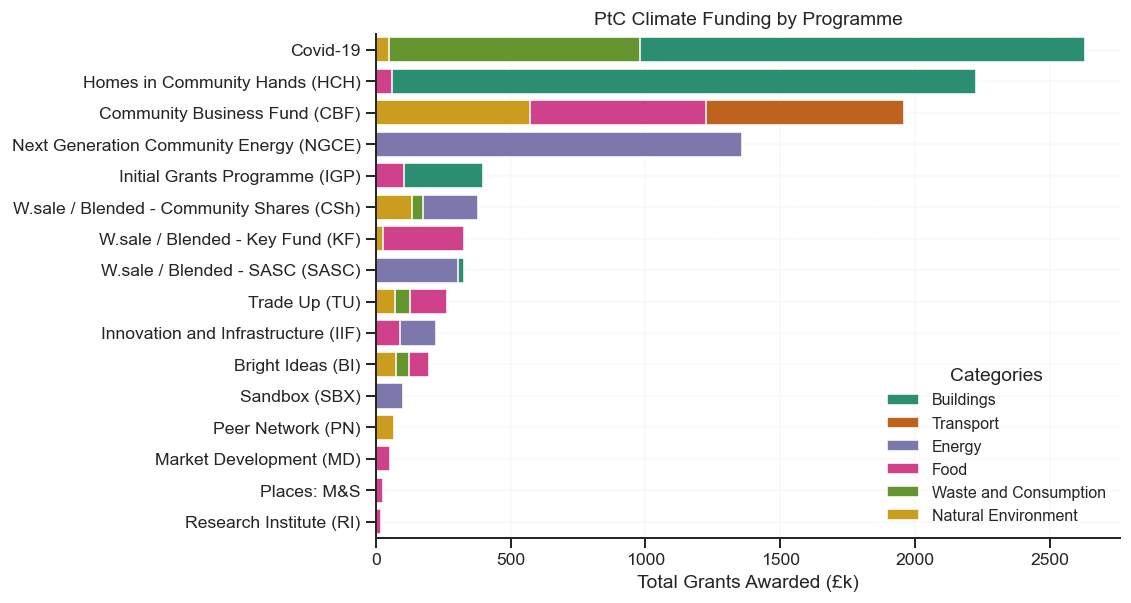

In [169]:
sns.catplot(x='Total Grants Awarded', y='Programme', kind = "bar",
            hue = 'main_category', palette = "Dark2", ci = None, aspect = 2, dodge = False,
            data=sum_totals_main_cat_programme, legend = False)
plt.title("PtC Climate Funding by Programme")
plt.xlabel("Total Grants Awarded (£k)")
plt.ylabel("")
plt.grid(linestyle='dotted', linewidth = .3)
plt.legend(loc="lower right", title = "Categories", title_fontsize = "medium", framealpha = 0, fontsize = 'small')
#plt.savefig('PtC_Climate_Funding_by_Sub_Category.png', dpi=150, bbox_inches='tight')
plt.show()

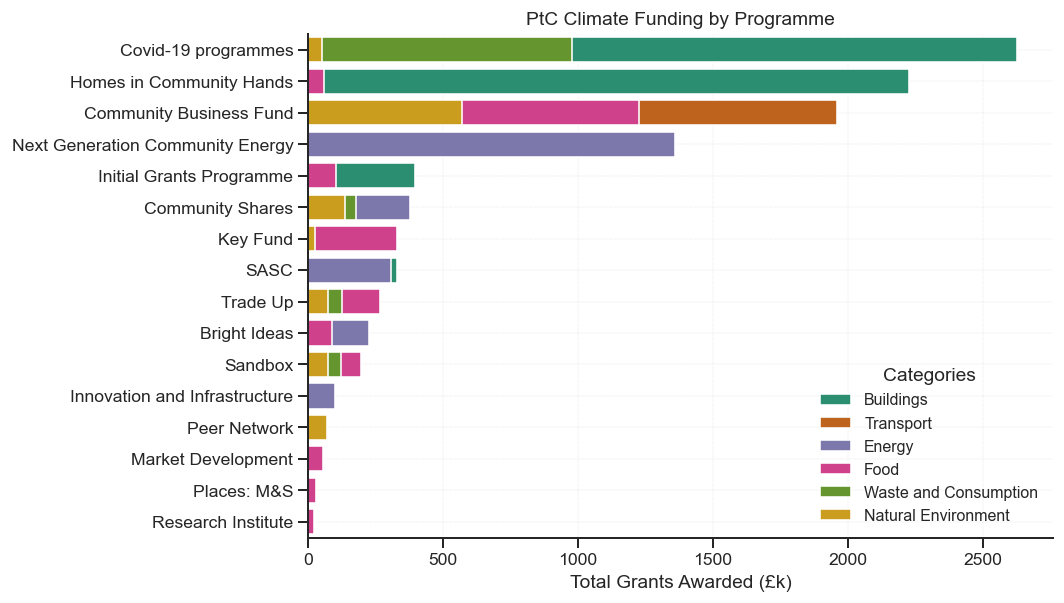

In [170]:
g = sns.catplot(x='Total Grants Awarded', y='Programme', kind = "bar",
            hue = 'main_category', palette = "Dark2", ci = None, aspect = 2, dodge = False,
            data=sum_totals_main_cat_programme, legend = False)
(g.set_yticklabels(["Covid-19 programmes", "Homes in Community Hands", "Community Business Fund", "Next Generation Community Energy", "Initial Grants Programme", 
                    "Community Shares", "Key Fund", "SASC", "Trade Up", "Bright Ideas", "Sandbox", "Innovation and Infrastructure", "Peer Network", 
                    "Market Development", "Places: M&S", "Research Institute"]))
plt.title("PtC Climate Funding by Programme")
plt.xlabel("Total Grants Awarded (£k)")
plt.ylabel("")
plt.grid(linestyle='dotted', linewidth = .3)
plt.legend(loc="lower right", title = "Categories", title_fontsize = "medium", framealpha = 0, fontsize = 'small')
plt.savefig('PtC_Climate_Funding_by_Programme.png', dpi=150, bbox_inches='tight')
plt.show()

### Give good examples for each subcategory 

In [56]:
subcategories= ["Electric Vehicles", "Innovative First/Last Mile Delivery", "Active Travel", "Community Transport", "Provision of housing", "Energy Efficiency (residential)", "Energy Efficiency (community buildings)", 
               "Energy Generation & Storage", "Energy Advice & Education", "Energy Finance", "Community Food Growing", "Diet & Education", "Food Provision", "Farming (Community Owned / Supported)",
               "Food Waste", "Repair & Re-use", "Retail & Consumerism", "Waste Streams", "Land use & biodiversity conservation", "Natural World "]

In [114]:
df_tagged_final[df_tagged_final['main_category'] == "Transport"]

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information,sub-category,main_category
37,0012400000RRad2AAD,APP-01229,Community Business Fund (CBF),Heeley Development Trust,Heeley Development Trust (CBF),Other,Charitable Trust,NaN,Transport,"Business or workspace,Employment support or tr...",...,276000.0,0.0,2016-09-19,"Heeley Development Trust (HDT) is a small, cha...",NaN,NaN,NaN,NaN,Active Travel,Transport
52,0012400000TbHjdAAF,APP-01378,Community Business Fund (CBF),Bristol Community Ferry Boats Ltd,Bristol Community Ferry Boats Ltd (CBF),Community Benefit Society,NaN,NaN,Transport,"Education support,Employment support or traini...",...,256875.0,0.0,2016-01-12,"Quote from Mark Tucker ""Power to Change fundin...",Bristol Ferry Fleet Project will commission an...,NaN,NaN,NaN,Electric Vehicles,Transport
69,0011p00002KoIeRAAV,APP-04910,Community Business Fund (CBF),Thorpe Edge Community Project,Thorpe Edge Community Project (CBF),Company Limited by Guarantee,NaN,2001.0,Transport,"Community space, hub or centre",...,120395.0,0.0,2019-10-17,We are a Community Development organisation ba...,To establish a local transport project as a Co...,NaN,NaN,NaN,Community Transport,Transport
72,0012400000RRaNpAAL,APP-04814,Community Business Fund (CBF),Bradford Trident,Bradford Trident Limited (CBF),Charitable Company Limited by Guarantee,NaN,2000.0,Buildings,Community café,...,308000.0,0.0,2019-10-15,"To engage, inspire and enable people to work t...",Putting a spring in the step of Parkside Sport...,NaN,NaN,NaN,Active Travel,Transport
116,0011p00002bS7tHAAS,APP-11457,W.sale / Blended - Community Shares (CSh),Lowther Arms Community Project (The Lowther Arms),Lowther Arms Community Project Limited (CSh),Community Benefit Society,Community Benefit Society (IPS Bencom),NaN,Waste and Consumption,nan,...,100000.0,0.0,2020-09-25,NaN,The community share offer aims to raise suffic...,NaN,NaN,NaN,Community Transport,Transport
157,0012400000mL17EAAS,APP-02163,Trade Up (TU),Lynher River Barge CIC,Lynher River Barge CIC (TU),Community Interest Company Limited by Guarantee,Charitable company limited by guarantee,NaN,Transport,"Community space, hub or centre;Education suppo...",...,10000.0,0.0,2018-01-30,NaN,The Lynher is a restored Tamar Barge that will...,NaN,NaN,NaN,Community Transport,Transport
202,0011p00002M3KlnAAF,APP-04211,Trade Up (TU),Mid Beds Link-A-Ride Community Transport Ltd,Mid Beds Link-A-Ride Community Transport Ltd (TU),Co-operative Society,NaN,NaN,Transport,Healthcare & mental health services,...,8750.0,0.0,2019-01-07,NaN,"Link-A-Ride began when the Health Authority, S...",NaN,NaN,NaN,Community Transport,Transport
214,0012400000RRalZAAT,APP-04291,Trade Up (TU),North Doncaster Development Trust,North Doncaster Development Trust (TU),Company Limited by Guarantee,Charitable Company,NaN,Transport,Transportation,...,10750.0,0.0,2019-02-07,North Doncaster Development Trust (NDDT) is a ...,North Doncaster Development Trust (NDDT) is a ...,NaN,NaN,NaN,Community Transport,Transport
247,0012400000qOrvRAAS,APP-01637,W.sale / Blended - Community Shares (CSh),Bythams Community Shop Limited,The Bythams Community Shop Ltd (CSh),Other (Please specify),Industrial and Provident Society,NaN,Waste and Consumption,"Community caf_,Community shop,Community space,...",...,20960.0,0.0,2017-01-04,LA - South Kesteven District Council & Lincoln...,Development Grant for Community Share Offer St...,NaN,NaN,NaN,Innovative First/Last Mile Delivery,Transport
324,0011p000021txN7AAI,APP-04539,Bright Ideas (BI),Sunshine Co-operative Community Interest Company,Sunshine Co-operative Community Interest Compa...,Community Interest Company Lim

In [129]:
pd.set_option("display.max_colwidth", -1)
#NW = df_tagged_final[df_tagged_final['sub-category'] == "Natural World "] \
#    .nlargest(10, 'Total Grants Awarded')
#NW[['App ID', 'Purpose (Project Description)']]
#LB = df_tagged_final[df_tagged_final['sub-category'] == "Land use & biodiversity conservation"] \
#    .nlargest(10, 'Total Grants Awarded')
#LB[['App ID', 'Purpose (Project Description)']]
#WS = df_tagged_final[df_tagged_final['sub-category'] == "Waste Streams"] \
#    .nlargest(10, 'Total Grants Awarded')
#WS[['App ID', 'Purpose (Project Description)']]
#RC = df_tagged_final[df_tagged_final['sub-category'] == "Retail & Consumerism"] \
#    .nlargest(10, 'Total Grants Awarded')
#RC[['App ID', 'Purpose (Project Description)']]
#RR = df_tagged_final[df_tagged_final['sub-category'] == "Repair & Re-use"] \
#    .nlargest(10, 'Total Grants Awarded')
#RR[['App ID', 'Purpose (Project Description)']]
#FW = df_tagged_final[df_tagged_final['sub-category'] == "Food Waste"] \
#    .nlargest(10, 'Total Grants Awarded')
#FW[['App ID', 'Purpose (Project Description)']]
#F = df_tagged_final[df_tagged_final['sub-category'] == "Farming (Community Owned / Supported)"] \
#    .nlargest(10, 'Total Grants Awarded')
#F[['App ID', 'Purpose (Project Description)']]
#FD = df_tagged_final[df_tagged_final['sub-category'] == "Food Provision"] \
#    .nlargest(15, 'Total Grants Awarded')
#FD[['App ID', 'Purpose (Project Description)']]
#CFG = df_tagged_final[df_tagged_final['sub-category'] == "Community Food Growing"] \
#    .nlargest(10, 'Total Grants Awarded')
#CFG[['App ID', 'Purpose (Project Description)']]
#EF = df_tagged_final[df_tagged_final['sub-category'] == "Energy Finance"] \
#    .nlargest(10, 'Total Grants Awarded')
#EF[['App ID', 'Purpose (Project Description)']]
#EAE = df_tagged_final[df_tagged_final['sub-category'] == "Energy Advice & Education"] \
#    .nlargest(10, 'Total Grants Awarded')
#EAE[['App ID', 'Purpose (Project Description)']]
#EG = df_tagged_final[df_tagged_final['sub-category'] == "Energy Generation & Storage"] \
#    .nlargest(10, 'Total Grants Awarded')
#EG[['App ID', 'Purpose (Project Description)']]
#EEC = df_tagged_final[df_tagged_final['sub-category'] == "Energy Efficiency (community buildings)"] \
    #.nlargest(10, 'Total Grants Awarded')
#EEC[['App ID', 'Purpose (Project Description)']]
#EER = df_tagged_final[df_tagged_final['sub-category'] == "Energy Efficiency (residential)"] \
#    .nlargest(12, 'Total Grants Awarded')
#EER[['App ID', 'Purpose (Project Description)']]
#ph = df_tagged_final[df_tagged_final['sub-category'] == "Provision of housing"] \
#    .nlargest(10, 'Total Grants Awarded')
#ph[['App ID', 'Purpose (Project Description)']]
#evs = df_tagged_final[df_tagged_final['sub-category'] == "Electric Vehicles"] \
    #.nlargest(10, 'Total Grants Awarded')
#evs[['App ID', 'Purpose (Project Description)']]
transport = transport.nlargest(10, 'Total Grants Awarded')
transport[['App ID', 'Purpose (Project Description)']]
#at = df_tagged_final[df_tagged_final['sub-category'] == "Active Travel"] \
#    .nlargest(10, 'Total Grants Awarded')
#at[['App ID', 'Purpose (Project Description)']]
#ct = df_tagged_final[df_tagged_final['sub-category'] == "Community Transport"] \
#    .nlargest(10, 'Total Grants Awarded')
#ct[['App ID', 'Purpose (Project Description)']]



<ipython-input-129-43b32fe6ab4c>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,App ID,Purpose (Project Description)
247,APP-01637,"Development Grant for Community Share Offer Standard Mark - The aim of our project is to build, equip and operate a community owned facility that will meet the dual objectives of providing access to retail and other services and serve as a social ?hub? for the residents of an isolated rural community. An initial survey of 9 potential existing premises was carried out in the two main villages in 2014. It quickly became apparent they all had 2 principal defects, the first was a footprint deemed too small for our purposes and the second that most had extremely limited or no parking space. Although a secondary objective of the project is to reduce vehicle mileage it was estimated that around 60% of customers had to use cars to get to the previous shop even within the bounds of the 2 Parishes. Fortunately the project Steering Group has been able to obtain a brownfield site, near to the geographic centre of the broader rural community it aims to serve. Moreover it will offer adequate off road parking. A new build design has allowed the project team to ensure an adequate footprint for both a retail area and a community cafe facility to meet its dual objectives of access to services and serving as a social hub. It has also allowed the project to consider options for maximising the building efficiency and, by the use of renewable energy resources, minimise the business carbon footprint and reduce its running costs. The external design of a timber frame and timber clad appearance has also been included to enhance its rural setting. Development Grant - Booster Programme, to help with Community Shares Standards Mark"
758,APP-01612,"The aim of our project is to build, equip and operate a community owned facility that will meet the dual objectives of providing access to retail and other services and serve as a social ?hub? for the residents of an isolated rural community. An initial survey of 9 potential existing premises was carried out in the two main villages in 2014. It quickly became apparent they all had 2 principal defects, the first was a footprint deemed too small for our purposes and the second that most had extremely limited or no parking space. Although a secondary objective of the project is to reduce vehicle mileage it was estimated that around 60% of customers had to use cars to get to the previous shop even within the bounds of the 2 Parishes. Fortunately the project Steering Group has been able to obtain a brownfield site, near to the geographic centre of the broader rural community it aims to serve. Moreover it will offer adequate off road parking. A new build design has allowed the project team to ensure an adequate footprint for both a retail area and a community cafe facility to meet its dual objectives of access to services and serving as a social hub. It has also allowed the project to consider options for maximising the building efficiency and, by the use of renewable energy resources, minimise the business carbon footprint and reduce its running costs. The external design of a timber frame and timber clad appearance has also been included to enhance its rural setting."
324,APP-04539,"Sunshine Co-operative is dedicated to improving our area and we would like a Community Shop (with small café) to become a place, with the community at its heart. By opening a shop in the East End of Sunderland, we wish to increase footfall, which will benefit other businesses nearby and in the historic Eagle Building. This will expand our current business as we currently run a local food delivery service out of this building - with an office and warehouse area but it also has the potential to be a shop and there are other areas of the building that can be utilised for workshops, group sessions and courtyard for events. Our service currently reaches residents who don?t necessarily come into Sunderland City Centre; feedback shows that people would be willing to travel to a shop, even if

In [127]:
transport = df_tagged_final[df_tagged_final['main_category'] == "Transport"]
transport = transport[(transport['sub-category'] != "Active Travel") & (transport['sub-category'] != "Electric Vehicles") & (transport['sub-category'] != "Community Transport")]
transport

,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information,sub-category,main_category
247,0012400000qOrvRAAS,APP-01637,W.sale / Blended - Community Shares (CSh),Bythams Community Shop Limited,The Bythams Community Shop Ltd (CSh),Other (Please specify),Industrial and Provident Society,NaN,Waste and Consumption,"Community caf_,Community shop,Community space, hub or centre,Energy generation,Food catering or production",...,20960.0,0.0,2017-01-04,LA - South Kesteven District Council & Lincolnshire County Council Nick Boles MP,"Development Grant for Community Share Offer Standard Mark - The aim of our project is to build, equip and operate a community owned facility that will meet the dual objectives of providing access to retail and other services and serve as a social ?hub? for the residents of an isolated rural community. An initial survey of 9 potential existing premises was carried out in the two main villages in 2014. It quickly became apparent they all had 2 principal defects, the first was a footprint deemed too small for our purposes and the second that most had extremely limited or no parking space. Although a secondary objective of the project is to reduce vehicle mileage it was estimated that around 60% of customers had to use cars to get to the previous shop even within the bounds of the 2 Parishes. Fortunately the project Steering Group has been able to obtain a brownfield site, near to the geographic centre of the broader rural community it aims to serve. Moreover it will offer adequate off road parking. A new build design has allowed the project team to ensure an adequate footprint for both a retail area and a community cafe facility to meet its dual objectives of access to services and serving as a social hub. It has also allowed the project to consider options for maximising the building efficiency and, by the use of renewable energy resources, minimise the business carbon footprint and reduce its running costs. The external design of a timber frame and timber clad appearance has also been included to enhance its rural setting. Development Grant - Booster Programme, to help with Community Shares Standards Mark",NaN,NaN,NaN,Innovative First/Last Mile Delivery,Transport
324,0011p000021txN7AAI,APP-04539,Bright Ideas (BI),Sunshine Co-operative Community Interest Company,Sunshine Co-operative Community Interest Company (BI),Community Interest Company Limited by Guarantee,NaN,NaN,Waste and Consumption,"Community Centre Hub, Facility or Space",...,14986.0,7000.0,2019-02-10,NaN,"Sunshine Co-operative is dedicated to improving our area and we would like a Community Shop (with small café) to become a place, with the community at its heart. By opening a shop in the East End of Sunderland, we wish to increase footfall, which will benefit other businesses nearby and in the historic Eagle Building. This will expand our current business as we currently run a local food delivery service out of this building - with an office and warehouse area but it also has the potential to be a shop and there are other areas of the building that can be utilised for workshops, group sessions and courtyard for events. Our service currently reaches residents who don?t necessarily come into Sunderland City Centre; feedback shows that people would be willing to travel to a shop, even if it is slightly outside the City Centre based on the level of service and quality of products we provide. Addressing our immediate community is the next step. We already have created a strong community with our local suppliers - one coming on board as a supporter. The owner of The Eagle Building is very eager to develop the shop front a

In [111]:
x = range(0, 19) 
list_df = ["df_", str(i), sep = "" for i in xrange(x,19)]
for i in x:
    list_df.append(str()  

TypeError: decoding str is not supported

In [137]:
list_df = list(map('df_{}'.format, range(0, 19)))
for x in list_df:
    x = x.strip('')
list_df

['df_0',
 'df_1',
 'df_2',
 'df_3',
 'df_4',
 'df_5',
 'df_6',
 'df_7',
 'df_8',
 'df_9',
 'df_10',
 'df_11',
 'df_12',
 'df_13',
 'df_14',
 'df_15',
 'df_16',
 'df_17',
 'df_18']

In [150]:
def programmes_size():
    """This function allows for the quick filtering of the largest programmes in each category"""
    
    for i in list_df:
        list_df[i] = df_tagged_final
            #dataframe_2 = dataframe_2[dataframe_2['sub-category'] == i]
            #dataframe_2 = dataframe_2.nlargest(10, 'Total Grants Awarded')
programmes_size()
list_df[1]

TypeError: list indices must be integers or slices, not str

In [59]:
for i in subcategories:
    print(i)

Electric Vehicles
Innovative First/Last Mile Delivery
Active Travel
Community Transport
Energy Efficiency (residential)
Energy Efficiency (community buildings)
Energy Generation & Storage
Energy Advice & Education
Energy Finance
Community Food Growing
Diet & Education
Food Provision
Farming (Community Owned / Supported)
Food Waste
Repair & Re-use
Retail & Consumerism
Waste Streams
Land use & biodiversity conservation
Natural World 


<ipython-input-174-0c6522a36536>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,App ID,Purpose (Project Description)


In [ ]:
def tagged_cat(fund_list, dataframe, array, tag_name):
    
    """This function allows for the quick tagging by Programme Type
    fund_list shoudl be a list, tag_name should be a string, array is the array that we want to check key words in
    Then it prints the number of covid relatated """
    
    
    if 'sub-category' in dataframe.columns:
        print("column already exists")
    else:
        dataframe['sub-category'] = ""
           
    for i in fund_list:
        dataframe.loc[array == i, ['sub-category']] = tag_name
        
    print("Number of", tag_name, "programmes:", len(dataframe[dataframe['sub-category'] == tag_name]))
  
tagged_cat(fund_list = covid_funds, dataframe = df_buildings, array = df_buildings.Programme  ,tag_name ='covid-19')

In [596]:
# df_tagged_final[df_tagged_final['App ID'] == 'APP-10065']
# df_tagged_final[df_tagged_final['App ID'] == 'APP-07935']
# df_tagged_final[df_tagged_final['App ID'] == 'APP-11602']
df_tagged_final[df_tagged_final['App ID'] == 'APP-02148']


,18 characters Org ID,App ID,Programme,Organisation Name,Application Name,Organisational Legal Structure,"If Legal Structure Other, specify",Year of Incorporation,Primary Sector - Org,Secondary Sector - Org,...,Total Grants Awarded,Total Value of Capacity Support Received,First Award Date,Organisation Overview,Purpose (Project Description),Main Aims,C-19 Purpose for Funding,Funding Information,sub-category,main_category
70,0011p00001VEHgzAAH,APP-02148,Trade Up (TU),Highway Hope,Highway Hope (TU),Charitable Incorporated Organisation,NaN,2013.0,Buildings,Community café;Community shop;Education support,...,10000.0,0.0,2018-01-19,"Highway Hope is a social enterprise aims to empower local people in particular those from BAME communities to achieve their full potential. This is achieved through a range of activities in Supplementary education, health and wellbeing services, training and trading initiatives to developing skills, increasing confidence and mental wellbeing.","Highway Hope - Registered 2013. Started in a church hall in the Gorton area of Manchester that they have now outgrown. The range of services provided cover the needs of broad sections of the community and include: Foodbank (accessed by 25 families each week ? currently open 1 day a week); Community Café ? drink/meals fee of charge (Mon-Sat); Charity shop clothing, toys and furniture (Mon-Sat). Education ? 10 children from mainstream schools for extra learning support, with a waiting list (Saturdays); Employability Work Club ? 70 unemployed people (Tuesdays), learning opportunities; catering and room hire; events for social inclusion; volunteering and general services. Trade up plans are to set up a health and wellbeing service/hub that can be self sustaining and compliments the services already offered by the community business. This will involve collaboration with local partners and may include gardening/landscaping, removal of garden waste and furniture etc. This will provide additional training and volunteering opportunities. They are currently seeking to move from the church premises into a bigger facility nearby. In discussion with local authority.",NaN,NaN,NaN,Food Provision,Food


### Calculate % of community businesses and total amount funded for climate & ecological action out of all grants (salesforce data)

In [171]:
print("Number of different Applications in original salesforce dataset:", len(df["App ID"].unique()))
print("Number of different Organisation IDs in original salesforce dataset:", len(df["18 characters Org ID"].unique()))
print("Total Salesforce Funding:", df['Total Grants Awarded'].sum()/1000000, "£million")

Number of different Applications in original salesforce dataset: 2477
Number of different Organisation IDs in original salesforce dataset: 1642
Total Salesforce Funding: 95.61310135000001 £million


In [172]:
print("Number of different Applications in final tagged salesforce dataset:", len(df_tagged_final["App ID"].unique()))
print("Number of different Organisation IDs in final tagged  salesforce dataset:", len(df_tagged_final["18 characters Org ID"].unique()))
print("Total Funding for final tagged dataset :", df_tagged_final['Total Grants Awarded'].sum()/1000000, "£million")

Number of different Applications in final tagged salesforce dataset: 461
Number of different Organisation IDs in final tagged  salesforce dataset: 335
Total Funding for final tagged dataset : 18.21508306 £million


In [173]:
print("% of climate funding out of total PtC funding:", (df_tagged_final['Total Grants Awarded'].sum()/df['Total Grants Awarded'].sum())*100, "%")

% of climate funding out of total PtC funding: 19.050823373380723 %


In [174]:
100 - 19.05

80.95

In [175]:
print("Number of different Applications in filtered dataset:", len(df_filtered["App ID"].unique()))
print("Number of different Organisation IDs in filtered dataset:", len(df_filtered["18 characters Org ID"].unique()))
print("Total Filtered Funding:", df_filtered['Total Grants Awarded'].sum()/1000000, "£million")

Number of different Applications in filtered dataset: 833
Number of different Organisation IDs in filtered dataset: 508
Total Filtered Funding: 30.27360671 £million


In [176]:
print("Number of different Applications in untagged filtered dataset:", len(untagged_filtered["App ID"].unique()))
print("Number of different Organisation IDs in untagged filtered dataset:", len(untagged_filtered["18 characters Org ID"].unique()))
print("Total untagged filtered Funding:", untagged_filtered['Total Grants Awarded'].sum()/1000000, "£million")
print("% of climate funding out of total PtC funding:", (untagged_filtered['Total Grants Awarded'].sum()/df['Total Grants Awarded'].sum())*100, "%")

Number of different Applications in untagged filtered dataset: 123
Number of different Organisation IDs in untagged filtered dataset: 99
Total untagged filtered Funding: 6.42918034 £million
% of climate funding out of total PtC funding: 6.724162535493364 %


In [177]:
print("As % of total funding")
print("% of climate untagged filtered funding out of total PtC funding:", (untagged_filtered['Total Grants Awarded'].sum()/df['Total Grants Awarded'].sum())*100, "%") 
print("% of pub and other climate funding out of total PtC funding:", (df_tagged_pubs_others['Total Grants Awarded'].sum()/ df['Total Grants Awarded'].sum())*100, "%") 
print("% of covid related climate funding out of total PtC funding:", (df_tagged_covid_only['Total Grants Awarded'].sum()/ df['Total Grants Awarded'].sum())*100, "%") 
print("% of pure climate funding out of total PtC funding:", (df_tagged_non_covid['Total Grants Awarded'].sum()/ df['Total Grants Awarded'].sum())*100, "%") 


As % of total funding
% of climate untagged filtered funding out of total PtC funding: 6.724162535493364 %
% of pub and other climate funding out of total PtC funding: 5.559195586118283 %
% of covid related climate funding out of total PtC funding: 3.778294971079295 %
% of pure climate funding out of total PtC funding: 15.344320864872769 %


In [178]:
100 - (15.344320864872769 + 3.778294971079295 + 5.559195586118283 + 6.724162535493364)

68.5940260424363

In [179]:
print("As % of number of grants")
print("% of climate untagged filtered funding out of total PtC grants:", (len(untagged_filtered['App ID'].unique())/ len(df["App ID"].unique())) *100, "%")
print("% of pub and other climate funding out of total PtC grants:", (len(df_tagged_pubs_others['App ID'].unique())/ len(df["App ID"].unique())) *100, "%")
print("% of covid related climate funding out of total PtC grants:", (len(df_tagged_covid_only['App ID'].unique())/ len(df["App ID"].unique())) *100, "%") 
print("% of pure climate funding out of total PtC grants:", (len(df_tagged_non_covid['App ID'].unique())/ len(df["App ID"].unique())) *100, "%") 


As % of number of grants
% of climate untagged filtered funding out of total PtC grants: 4.9656842955187726 %
% of pub and other climate funding out of total PtC grants: 9.931368591037545 %
% of covid related climate funding out of total PtC grants: 7.3072264836495755 %
% of pure climate funding out of total PtC grants: 11.344368187323376 %


In [180]:
100 - (4.9656842955187726 + 9.931368591037545 + 7.3072264836495755 + 11.344368187323376)

66.45135244247074

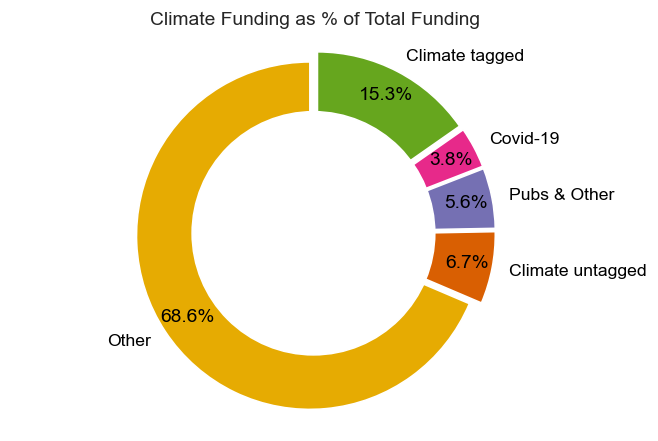

In [181]:
fig, ax = plt.subplots()

## COVID, PUBS and other, Untagged Filtered, Filtered, Climate


## Pie Chart 
breakdown = ['Other','Climate untagged', 'Pubs & Other', "Covid-19", "Climate tagged"]
percentages = ['68.6', '6.7', '5.6', "3.8", "15.3"]

## Explode 
explode = (0.025,0.05,0.05,0.05,0.05)

#Colours
colors = ["#E6AB02", "#D95F02", "#7570B3", "#E7298A", "#66A61E"]

## Plot
patches, texts, autotexts = ax.pie(percentages, colors = colors, explode = explode, pctdistance= 0.85,
                                   labels = breakdown, startangle=90, autopct = '%1.1f%%')

for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')

    
## Draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)



## Equal aspect ratio ensures that pie is drawn as a circle 
ax.axis('equal')

ax.set_title("Climate Funding as % of Total Funding")


plt.savefig('climate_funding_by_total_funding.png', dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()

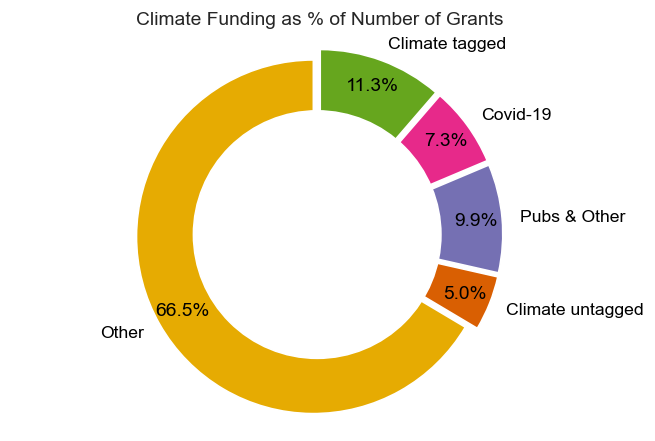

In [182]:
fig, ax = plt.subplots()

## COVID, PUBS and other, Untagged Filtered, Filtered, Climate


## Pie Chart 
breakdown = ['Other','Climate untagged', 'Pubs & Other', "Covid-19", "Climate tagged"]
percentages = ['66.45', '5.0', '9.9', "7.3", "11.34"]

## Explode 
explode = (0.025,0.05,0.05,0.05,0.05)

#Colours
colors = ["#E6AB02", "#D95F02", "#7570B3", "#E7298A", "#66A61E"]

## Plot
patches, texts, autotexts = ax.pie(percentages, colors = colors, explode = explode, pctdistance= 0.85,
                                   labels = breakdown, startangle=90, autopct = '%1.1f%%')

for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')

    
## Draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)



## Equal aspect ratio ensures that pie is drawn as a circle 
ax.axis('equal')
ax.set_title("Climate Funding as % of Number of Grants")


plt.savefig('climate_funding_by_total_applications.png', dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Climate relevance analysis

In [22]:
df_tagged_final = pd.read_excel('df_tagged_final.xlsx', parse_dates= ['First Award Date'])

In [31]:
dictionary_Impact = {
    "Electric Vehicles" : 'High',
    "Innovative First/Last Mile Delivery " :  'High',
    "Active Travel" : "High",
    "Community Transport" : "High",
    "Energy Efficiency (residential)" : 'High', 
    "Energy Efficiency (community buildings)": "High",
    "Provision of housing" : "Low",
    "Energy Generation & Storage" : "High",
    "Energy Advice & Education" : "Medium",
    "Energy Finance" : "High",
    "Community Food Growing" : "Medium",
    "Diet & Education" : "Low",
    "Food Provision": "Low",
    "Farming (Community Owned / Supported)" : "Medium",
    "Food Waste" : "Medium",
    "Repair & Re-use" : "Medium",
    "Retail & Consumerism" : "Medium",
    "Waste Streams" : "High", 
    "Land use & biodiversity conservation" : "High",
    "Natural World " : "Medium"
}
impact = df_tagged_final

In [35]:
#dictionary_Impact_new = {keys: old_keys for old_keys, old_values in dictionary_Impact.items() for keys in old_values}
impact['Climate Relevance'] = impact['sub-category'].replace(dictionary_Impact)
impact = impact[impact['Climate Relevance'] != "covid-19"]
impact_sum = impact.groupby("Climate Relevance").sum()
impact_sum = impact_sum.reset_index(level=0)
total = 8796920.04+3210637.02+2663624.00
impact_sum["Percent"] = (impact_sum["Total Grants Awarded"]/total)*100
impact_sum

<ipython-input-35-a334939eaf61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impact['Climate Relevance'] = impact['sub-category'].replace(dictionary_Impact)


,Climate Relevance,Year of Incorporation,IMD Average,Total Grants Awarded,Total Value of Capacity Support Received,Percent
0,High,54195.0,476,8796920.04,144935.32,59.960544
1,Low,26116.0,205,3210637.02,97417.23,21.883971
2,Medium,48177.0,288,2663624.00,115375.69,18.155484


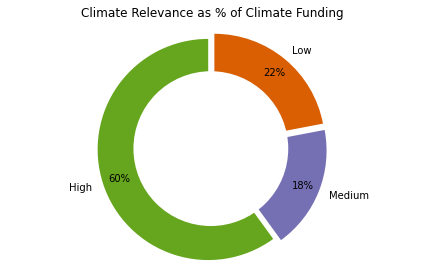

In [43]:
fig, ax = plt.subplots()

## COVID, PUBS and other, Untagged Filtered, Filtered, Climate


## Pie Chart 
breakdown = ['High','Medium', 'Low']
percentages = ['60', '18', '22']

## Explode 
explode = (0.025,0.05,0.05)

#Colours
colors = ["#66A61E", "#7570B3", "#D95F02"]

## Plot
patches, texts, autotexts = ax.pie(percentages, colors = colors, explode = explode, pctdistance= 0.85,
                                   labels = breakdown, startangle=90, autopct = '%1.0f%%')

for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')

    
## Draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)



## Equal aspect ratio ensures that pie is drawn as a circle 
ax.axis('equal')
ax.set_title("Climate Relevance as % of Climate Funding")


plt.savefig('climate_funding_by_climate_relevance.png', dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()